# chapter figures

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import cartopy
import cartopy.crs as ccrs
import cmocean.cm as cmo
import gsw
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from datetime import datetime
from utility_functions import scale_bar, dist_to_coords, savefig, letterboxes, turner_cmap, labels, edge_to_centre
from detect_staircases import classify_staircase
style.use('presentation.mplstyle')

In [2]:
from data_prep import glider_df, glider_av_df
ds_vdb = xr.open_dataset('data/vanderboog_argo_data.nc')
df_dissapation = pd.read_csv('data/microstructure_dissapation.csv')

In [3]:
good_dive_mask = np.empty((len(glider_df)), dtype=bool)
good_dive_mask[:] = True
bad_dives = (22, 22.5, 23, 23.5, 41, 41.5, 42, 42.5, 43, 43.5, 47, 47.5) # Dives where sg637 stalled
for dive in bad_dives:
    good_dive_mask[(glider_df.dive_num==dive) & (glider_df.glider=='sg637')] = False
glider_df = glider_df[good_dive_mask]

In [4]:
df_glider_1m = pd.read_csv('data/glider_1m_staircase.csv', low_memory=False)
mixes = pd.read_csv('data/glider_1m_mixed_layers.csv')
grads = pd.read_csv('data/glider_1m_grad_layers.csv')

In [5]:
df_glider_1m_both = pd.read_csv('/media/callum/storage/Documents/Eureka/processing/staircase_experiment/reimplement/salt_and_temp_flag_glider_1m_staircase.csv', low_memory=False)
mixes_both = pd.read_csv('/media/callum/storage/Documents/Eureka/processing/staircase_experiment/reimplement/salt_and_temp_flag_glider_1m_mixed_layers.csv')
grads_both = pd.read_csv('/media/callum/storage/Documents/Eureka/processing/staircase_experiment/reimplement/salt_and_temp_flag_glider_1m_grad_layers.csv')

In [6]:
mixes = mixes[mixes.salt_finger_step]
grads = grads[grads.salt_finger_step]
mixes_both = mixes_both[mixes_both.salt_finger_step]
grads_both = grads_both[grads_both.salt_finger_step]

# Summary stats

In [8]:
extent = 0
for glider in glider_df.glider.unique():
    time = glider_df[glider_df.glider==glider].time_yday_utc
    extent = extent + (time.max()-time.min())
print(f"number of glider days = {extent}")

number of glider days = 55.998854166666675


In [9]:
num_profiles = 2 *len(glider_df.dive_limb_ident.unique())
print(f"number of glider profiles = {num_profiles}")

number of glider profiles = 1162


In [12]:
deep_dives = glider_df[glider_df.depth>300]
num_profiles_deep = 2 *len(deep_dives.dive_limb_ident.unique())
print(f"number of glider profiles > 300 m = {num_profiles_deep}")

number of glider profiles > 300 m = 682


In [10]:
mixes_deep = mixes[mixes.p>300]
dives_with_mixes = len(mixes_deep.dive.unique())
mixes_deep_both = mixes_both[mixes_both.p>300]
dives_with_mixes_both = len(mixes_deep_both.dive.unique())
print(f"proportion dives with steps:{dives_with_mixes}, {dives_with_mixes_both} ")

proportion dives with steps:666, 652 


In [14]:
prop_with_steps = 100 * dives_with_mixes / num_profiles_deep
prop_with_steps_both = 100 * dives_with_mixes_both / num_profiles_deep
print(f"proportion dives with steps:{prop_with_steps}, {prop_with_steps_both}%")

proportion dives with steps:97.65395894428153, 95.60117302052785%


In [17]:
mean_number_layers = len(mixes_deep) / num_profiles_deep
mean_number_layers_both = len(mixes_deep_both) / num_profiles_deep
print(f"mean steps per profiles = {mean_number_layers}, {mean_number_layers_both}")

mean steps per profiles = 14.312316715542522, 6.690615835777126


In [88]:
mixes[mixes.layer_height>9.5]
len(mixes[mixes.layer_height>9.5]) / len(glider_av_df)


1.071917808219178

In [89]:
len(mixes) / len(glider_av_df)

8.001712328767123

In [24]:
def vanderboog_stats(df_mix, df_grad, min_per=0.025, max_per=0.975):
    p_min = df_mix.p_start.quantile(min_per)
    p_max = df_mix.p_end.quantile(max_per)
    dt_min = df_grad.ct_range.quantile(min_per)
    dt_max = df_grad.ct_range.quantile(max_per)
    ds_min = df_grad.sa_range.quantile(min_per)
    ds_max = df_grad.sa_range.quantile(max_per)
    h_min = df_grad.layer_height.quantile(min_per)
    h_max = df_grad.layer_height.quantile(max_per)
    turn_min = df_grad.turner_ang.quantile(min_per)
    turn_max = df_grad.turner_ang.quantile(max_per)
    den_rat_min = df_grad.density_ratio.quantile(min_per)
    den_rat_max = df_grad.density_ratio.quantile(max_per)
    mh_min = df_mix.layer_height.quantile(min_per)
    mh_max = df_mix.layer_height.quantile(max_per)
    print(f"depth range {int(p_min)} - {int(p_max)} dbar")
    print(f"temperature step range {dt_min:.2f} - {dt_max:.2f} C")
    print(f"salinity step range {ds_min:.4f} - {ds_max:.4f} g/kg")
    print(f"thickness range {int(h_min)} - {int(h_max)} dbar")
    print(f"mixed llayer thickness range {int(mh_min)} - {int(mh_max)} dbar")    
    print(f"Turner angle {int(turn_min)} - {int(turn_max)}")
    print(f"Density ratio {den_rat_min:.2f} - {den_rat_max:.2f}")

vanderboog_stats(mixes,grads)

depth range 273 - 756 dbar
temperature step range 0.01 - 0.70 C
salinity step range 0.0000 - 0.1231 g/kg
thickness range 1 - 13 dbar
mixed llayer thickness range 1 - 22 dbar
Turner angle 51 - 82
Density ratio 1.31 - 7.78


In [26]:
vanderboog_stats(mixes_both,grads_both)

depth range 300 - 766 dbar
temperature step range 0.01 - 0.69 C
salinity step range 0.0011 - 0.1076 g/kg
thickness range 1 - 14 dbar
mixed llayer thickness range 1 - 19 dbar
Turner angle 51 - 81
Density ratio 1.31 - 7.83


In [16]:
ctd_df = pd.read_csv('data/meteor_ctd_proc.csv')

In [17]:
df_micro_1m = pd.read_csv('data/micro_1m_staircase.csv')

/home/callum/anaconda3/envs/sci/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (15,16,17,18,19,20,21,22) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
good_dive_mask = np.empty((len(glider_df)), dtype=bool)
good_dive_mask[:] = True
bad_dives = (22, 22.5, 23, 23.5, 41, 41.5, 42, 42.5, 43, 43.5, 47, 47.5) # Dives where sg637 stalled
for dive in bad_dives:
    good_dive_mask[(glider_df.dive_num==dive) & (glider_df.glider=='sg637')] = False
glider_df = glider_df[good_dive_mask]

In [19]:
good_dive_mask = np.empty((len(df_glider_1m)), dtype=bool)
good_dive_mask[:] = True
bad_dives = (22, 22.5, 23, 23.5, 41, 41.5, 42, 42.5, 43, 43.5, 47, 47.5) # Dives where sg637 stalled
for dive in bad_dives:
    good_dive_mask[df_glider_1m.dive==dive+2000] = False
df_glider_1m = df_glider_1m[good_dive_mask]

In [20]:
df_melon = glider_av_df.loc[(glider_av_df.dive_limb_ident>1000) & (glider_av_df.dive_limb_ident<2000)]
df_hump = glider_av_df.loc[glider_av_df.dive_limb_ident<1000]
df_omura = glider_av_df.loc[glider_av_df.dive_limb_ident>2000]

In [21]:
gebco_bathy = xr.open_dataset('data/eurec4a_bathy.nc')
lon = gebco_bathy.lon
lat = gebco_bathy.lat
bathy = gebco_bathy.elevation.values
bathy[bathy>-1] = -1
land_10m = cartopy.feature.NaturalEarthFeature('physical', 'coastline', '10m',
                                        edgecolor='k', facecolor='palegreen')
land_50m = cartopy.feature.NaturalEarthFeature(name='land',
                                              category='physical',
                                              scale='50m',
                                              edgecolor='k', facecolor='palegreen')

In [22]:
old_center = [-57.245, 14.182]
center = dist_to_coords(old_center, [-11, 1], shift_units='km')

shift_dist = 10
shift_meteor = [[shift_dist, shift_dist],
                [shift_dist, -shift_dist],
                [-shift_dist, -shift_dist],
                [-shift_dist, shift_dist]]
meteor_grid = np.array([dist_to_coords(center, shift_meteor[i], shift_units='km') for i in range(4)])

In [23]:
lat = np.array(lat)
lon = np.array(lon)
def geo_nearest(lon_input, lat_input):
    lat_index  = np.nanargmin((lat-lat_input)**2)
    lon_index = np.nanargmin((lon-lon_input)**2)
    return lon[lon_index], lat[lat_index], bathy[lat_index, lon_index]
geo_nearest = np.vectorize(geo_nearest)
path_lon, path_lat , path_bath =  geo_nearest(glider_av_df.lon, glider_av_df.lat)
bathy_per_dive = pd.DataFrame({'dive_limb_ident':glider_av_df.dive_limb_ident, 'bathy':path_bath})

In [24]:
glider_av_df['bathy_per_dive'] = bathy_per_dive.bathy

glider_df['bathy_per_dive'] = np.nan

for row in bathy_per_dive.index:
    glider_df.loc[glider_df.dive_limb_ident==bathy_per_dive.dive_limb_ident[row], 'bathy_per_dive'] = bathy_per_dive.bathy[row]

def add_z_bin(df_in, z_bin_size = 1):
    z_centers = np.arange(-np.round(np.nanmax(df_in.depth),0)+z_bin_size/2, 0, z_bin_size)
    noot = []
    z_center_loc = []
    for depth in df_in.depth:
        noot.append(np.abs(z_centers+depth).argmin())
        z_center_loc.append(z_centers[np.abs(z_centers+depth).argmin()])
    df_in['depth_bin']= noot
    df_in['bin_centers'] = z_center_loc
    return df_in
glider_df = add_z_bin(glider_df, z_bin_size=2)
glider_df['z_dive_bin'] = glider_df['depth_bin'] + 1000*glider_df['dive_limb_ident']

In [25]:
sg579_df = df_hump[df_hump.onsite==1.0]
sg620_df = df_melon
sg637_df = df_omura

In [26]:
sg637_present = [sg637_df.glider_time.values[0], sg637_df.glider_time.values[-1]]
sg620_present = [sg620_df.glider_time.values[0], sg620_df.glider_time.values[-1]]
sg579_present = [sg579_df.glider_time.values[0], sg579_df.glider_time.values[-1]]
platform_labels = ['SG579 Humpback', 'SG620 Melonhead', 'SG637 Omura']
platform_colors=['C0', 'C1', 'C2']
ctd_outer_box_locs = ctd_df[ctd_df.outer_box].groupby('cast_no').first()
ctd_center_locs = ctd_df[ctd_df.center_bowtie].groupby('cast_no').first()

In [27]:
platform_colors=['C1', 'C0', 'C2']


In [28]:
csalt_corners = pd.read_csv('csalt-ctds.txt')
csalt_dx = csalt_corners.lon[0] - csalt_corners.lon[1]
csalt_dy = csalt_corners.lat[0] - csalt_corners.lat[1]
csalt_dx_lat = (csalt_corners.lon[3] - csalt_corners.lon[0])/7
csalt_dy_lon = (csalt_corners.lat[3] - csalt_corners.lat[0])/7

In [29]:
csalt_dx = 3.5
csalt_dy = 2
csalt_base = [csalt_corners.lon[0], csalt_corners.lat[0]]
csalt_x = np.linspace(-csalt_base[0], 3.5-csalt_base[0], 9)
csalt_y = np.linspace(csalt_base[1], csalt_base[1]-2, 9)

In [30]:
csalt_ctd_lon = np.empty((9,8))
csalt_ctd_lat = np.empty((9,8))
csalt_ctd_lon[:,-1] = csalt_x
csalt_ctd_lat[:,-1] = csalt_y
for i in np.arange(8):
    csalt_ctd_lon[:,7-i] = csalt_x - csalt_dx_lat*i
    csalt_ctd_lat[:,7-i] = csalt_y + csalt_dy_lon*i

In [31]:
strong_x = [-57.4, -57.375, -57.0625,-56.9, -56.625, -55, -55]
strong_y = [15, 14.125, 13.65, 13.45 , 13.05, 8, 15]
weak_x = [-58.5, -58.0, -56.9, -56.625, -55, -58]
weak_y = [12.55,12.9, 13.45 , 13.05, 8, 8]
weak = np.array((weak_x, weak_y)).T
strong = np.array((strong_x, strong_y)).T

/media/callum/storage/Documents/Eureka/processing/paper_figures/utility_functions.py:186: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)


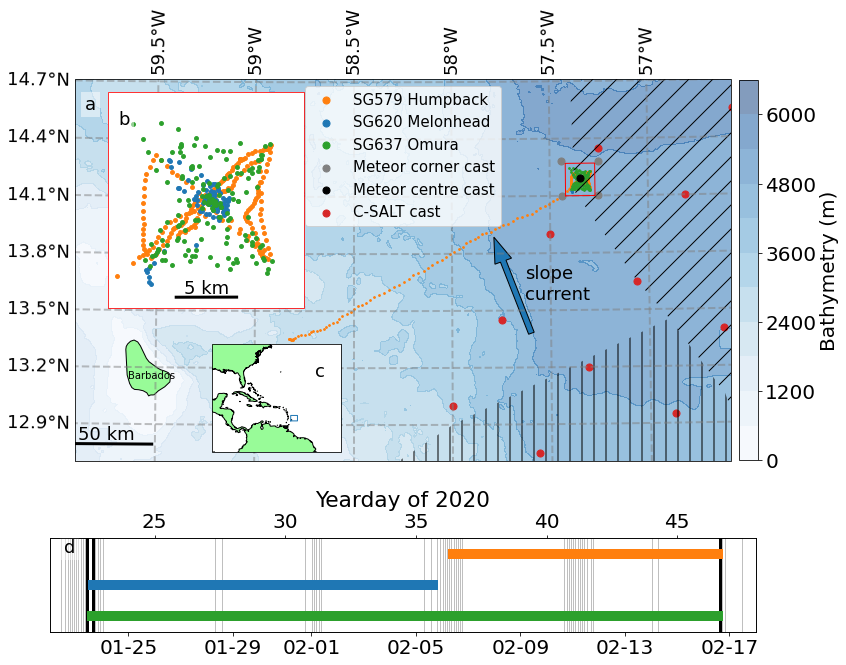

In [32]:
fig = plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.AlbersEqualArea(central_longitude=-58.5, central_latitude=13.5))
coord=ccrs.PlateCarree()
ax.add_feature(land_10m)
ax.set_extent([-59.9, -56.6, 12.7, 14.7], crs=ccrs.PlateCarree());
mappable0 = ax.contourf(lon, lat, -bathy,10, transform=ccrs.PlateCarree(), cmap = 'Blues', alpha=0.5, zorder=-10)
gl = ax.gridlines(draw_labels=True, 
                 linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.bottom_labels=None
gl.right_labels=None
dot_size=3
dot_size_zoom=15
dot_size_p=50
ax.scatter(df_melon.lon, df_melon.lat,transform=ccrs.PlateCarree(), s=dot_size)
ax.scatter(df_hump.lon, df_hump.lat,transform=ccrs.PlateCarree(), s=dot_size)
ax.scatter(df_omura.lon, df_omura.lat,transform=ccrs.PlateCarree(), s=dot_size)

ax.scatter(df_hump.lon+100, df_hump.lat,transform=ccrs.PlateCarree(), s=dot_size_p, label='SG579 Humpback', c='C1')
ax.scatter(df_melon.lon+100, df_melon.lat,transform=ccrs.PlateCarree(), s=dot_size_p, label='SG620 Melonhead', c='C0')
ax.scatter(df_omura.lon+100, df_omura.lat,transform=ccrs.PlateCarree(), s=dot_size_p, label='SG637 Omura', c='C2')
ax.scatter(meteor_grid[:, 0], meteor_grid[:,1], transform = ccrs.PlateCarree(), color='gray',s=dot_size_p, label='Meteor corner cast')
ax.scatter(*center, transform = ccrs.PlateCarree(), color='k',s=dot_size_p, label='Meteor centre cast')
ax.plot([-57.42, -57.42, -57.27, -57.27, -57.42], [14.1, 14.27, 14.27, 14.1, 14.1], color='red', transform = ccrs.PlateCarree())

# C-SALT

ax.scatter(csalt_ctd_lon, csalt_ctd_lat,transform=ccrs.PlateCarree(),  c='C3', s=dot_size_p, label='C-SALT cast')
p = patches.Polygon(strong, linewidth=0, fill=None, hatch='/', transform=ccrs.PlateCarree())
ax.add_patch(p)
p = patches.Polygon(weak, linewidth=0, fill=None, hatch='|', transform=ccrs.PlateCarree())
ax.add_patch(p)

ax.legend(loc=9)

fig.colorbar(mappable=mappable0, ax=ax, label='Bathymetry (m)', shrink=0.7, pad=0.01)


tr2=ccrs.Stereographic(central_latitude=14, central_longitude=-58)
big_ax = plt.axes([0.25, 0.25, 0.15, 0.15], projection=tr2)
big_ax.set_extent([-90,-40, 0, 40], crs=ccrs.PlateCarree())
big_ax.add_feature(land_50m)
big_ax.plot([-59.9, -59.9, -57.1, -57.1, -59.9], [ 12.8, 15, 15,  12.8,  12.8], color='C0', transform = ccrs.PlateCarree())


sub_ax = plt.axes([0.13, 0.45, 0.25, 0.3], projection=ccrs.AlbersEqualArea(central_longitude=-57.5, central_latitude=14))
sub_ax.set_extent([-57.42, -57.27, 14.1, 14.27], crs=ccrs.PlateCarree())
sub_ax.scatter(df_hump.lon, df_hump.lat,transform=ccrs.PlateCarree(), s=dot_size_zoom, label='sg620 Humpback', c='C1')
sub_ax.scatter(df_melon.lon, df_melon.lat,transform=ccrs.PlateCarree(), s=dot_size_zoom, label='sg579 Melonhead', c='C0')
sub_ax.scatter(df_omura.lon, df_omura.lat,transform=ccrs.PlateCarree(), s=dot_size_zoom, label='sg637 Omura', c='C2')
for child in sub_ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('red')

scale_bar(ax, location=(0.05,0.05))
scale_bar(sub_ax, location=(0.5,0.05), length=5)
ax.text(-59.64, 13.14, 'Barbados', transform = ccrs.PlateCarree(), fontsize=10)

ax0 = plt.axes([0.1, 0, 0.7, 0.13])
for i, glider_span in enumerate([sg579_present, sg620_present, sg637_present]):
    ax0.plot(glider_span, [-i,-i], linewidth=10, label=platform_labels[i], zorder=10, color=platform_colors[i])
ax0.plot([0,0],[i+1, i+1], label='Meteor box cast', color='gray', linewidth=0.5)
for cast in ctd_outer_box_locs.datetime_first_scan:
    ax0.axvline(cast, color='gray', linewidth=0.5)
ax0.plot([0,0],[i+1, i+1], label='Meteor center cast', color='k', linewidth=3)
for cast in ctd_center_locs.datetime_first_scan:
    ax0.axvline(cast, color='k', linewidth=3)
ax0.set(xlim=[datetime(2020,1,22), datetime(2020,2,18)], ylim=[-2.5, 0.5])
myFmt = mdates.DateFormatter('%m-%d')
ax0.xaxis.set_major_formatter(myFmt)
ax1 = ax0.twiny()
ax1.plot(range(100), np.ones(100)*100) 

ax1.set_xlim([datetime(2020,1,22).timetuple().tm_yday-1, datetime(2020,2,18).timetuple().tm_yday-1])
ax0.set_title('Yearday of 2020')
ax0.set_yticks([]);
letterboxes([ax, sub_ax, big_ax, ax0], loc=[[0.015, 0.92], [0.05, 0.85], [0.8, 0.7], [0.02, 0.85]])
ax.arrow(-57.6, 13.38, -0.14, 0.38, transform = ccrs.PlateCarree(), width=0.03, zorder=-1)
ax.text(-57.63, 13.56, 'slope\ncurrent', transform = ccrs.PlateCarree())
savefig('basemap')
savefig('fig02', extension='pdf')

# Tempsal scatter

In [33]:
omura_scat = glider_df.loc[(glider_df.glider=='sg637')]

In [34]:
omura_mix = mixes[mixes.dive>2000].copy()
bad_dives = (22, 22,5, 23, 23.5, 41, 41.5, 42, 42.5, 43, 43.5, 47, 47.5) # Dives where sg637 stalled
for dive in bad_dives:
    omura_mix[omura_mix.dive-2000==dive] = np.nan
omura_mix[omura_mix.sa>37.4] = np.nan

In [35]:
temp_step, sal_step = 0.1, 0.01
temp_grid = np.arange(5, 30, temp_step)
sal_grid = np.arange(34.5, 38, sal_step)
count_grid = np.zeros((len(temp_grid), len(sal_grid)))
for i, t in enumerate(temp_grid):
    for j, s in enumerate(sal_grid):
        df = omura_scat.loc[((np.abs(omura_scat.cons_temp - t))<temp_step/2) &
                            ((np.abs(omura_scat.abs_salinity - s))<sal_step/2)]
        count_grid[i, j] = len(df)
count_grid[count_grid==0] = np.nan   

ml_count_grid = np.zeros((len(temp_grid), len(sal_grid)))
for i, t in enumerate(temp_grid):
    for j, s in enumerate(sal_grid):
        df = omura_mix.loc[((np.abs(omura_mix.ct - t))<temp_step/2) &
                            ((np.abs(omura_mix.sa - s))<sal_step/2)]
        ml_count_grid[i, j] = len(df)
ml_count_grid[ml_count_grid<2] = np.nan  

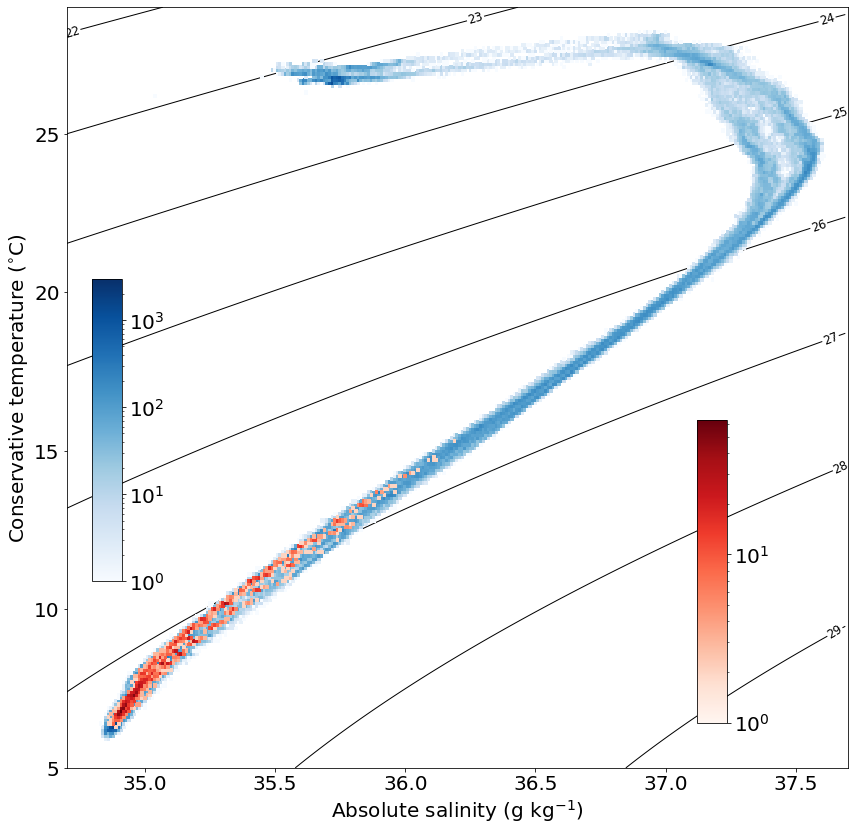

In [36]:
fig,ax = plt.subplots(1,1,figsize=(14,14))
den = ax.pcolor(sal_grid, temp_grid, count_grid,  norm=LogNorm(vmin=1, vmax=np.nanmax(count_grid)), shading='auto', cmap='Blues', zorder=-1)
#ax.scatter(omura_scat.abs_salinity, omura_scat.cons_temp, c=omura_scat.time_yday_local, alpha=0.3)
#ax.scatter(glider_350.abs_salinity, glider_350.cons_temp, c=glider_350.time_yday_local, alpha=0.3)
#mappable1 = ax.scatter(omura_mix.sa, omura_mix.ct, c=omura_mix.turner_ang,vmin=-180, vmax=180, s=1, cmap=turner_cmap)
ml_den = ax.pcolor(sal_grid, temp_grid, ml_count_grid,  norm=LogNorm(vmin=1, vmax=np.nanmax(ml_count_grid)), shading='auto', cmap='Reds', zorder=-1)

sal_lim = [34.7, 37.7]
temp_lim = [5, 29]
sal_ex,temp_ex = np.meshgrid(np.arange(sal_lim[0], sal_lim[1],0.01), np.arange(temp_lim[0],temp_lim[1],0.01))
seawater_density = gsw.rho(sal_ex, temp_ex, 0)
den_conts = np.arange(0,30,1)
mappable0=ax.contour(sal_ex[0,:],temp_ex[:,0],seawater_density-1000,den_conts,colors='k', zorder=-10)
#ax.clabel(mappable0)
ax.clabel(mappable0, inline=1,inline_spacing=0,fmt='%i', fontsize=12)
ax.set(xlim=sal_lim, ylim=temp_lim, xlabel=labels['sal'], ylabel=labels['temp'])
sub_ax =  plt.axes([0.15, 0.31, 0.03, 0.3])
fig.colorbar(mappable=den, cax=sub_ax)
sub_ax0 =  plt.axes([0.75, 0.17, 0.03, 0.3])
fig.colorbar(mappable=ml_den, cax=sub_ax0)
savefig('tempsal_scatter')
savefig('fig04', extension='pdf')

# Staircase

In [19]:
glider_df['dive_limb_dec'] = glider_df.dive_limb_ident - glider_df.dive + glider_df.dive_num

/tmp/ipykernel_16714/843323579.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  glider_df['dive_limb_dec'] = glider_df.dive_limb_ident - glider_df.dive + glider_df.dive_num


In [20]:
df_glider_1m['ml_mask_10m_plus'] = True
for i, mix in mixes.iterrows():
    if (mix.layer_height>=10) and (mix.bad_mixed_layer==False):
        df_glider_1m.loc[(df_glider_1m.p >= mix.p_start) & (df_glider_1m.p <= mix.p_end) &(df_glider_1m.dive == mix.dive), 'ml_mask_10m_plus'] = False

In [21]:
mixes_sum = mixes.groupby('dive').sum()
mixes_mean = mixes.groupby('dive').mean()
grads_sum = grads.groupby('dive').sum()
grads_mean = grads.groupby('dive').mean()

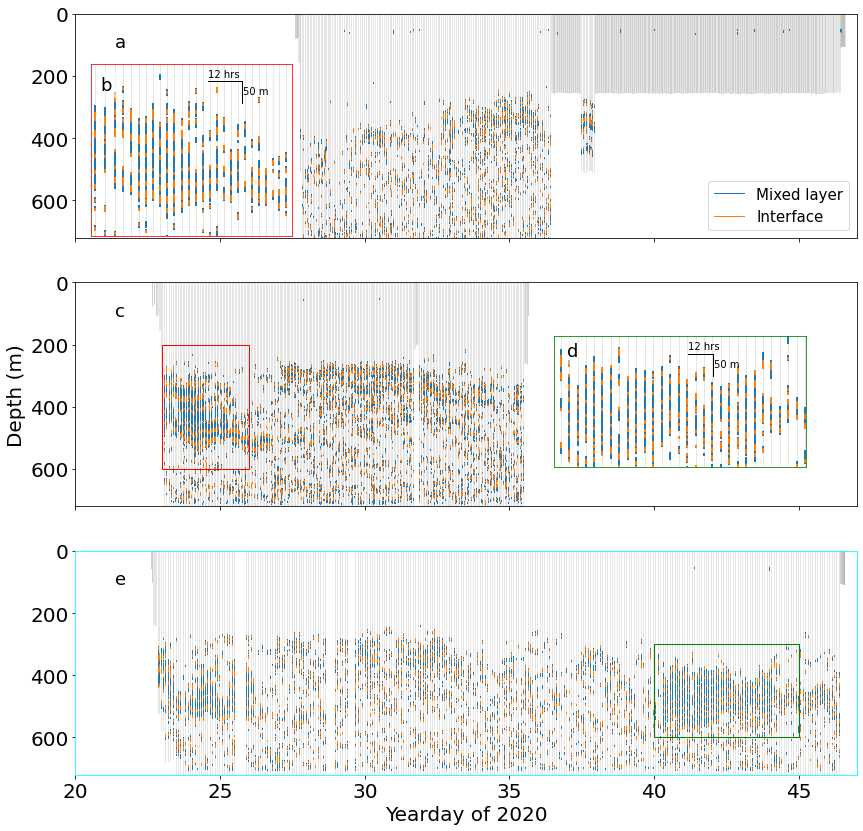

In [22]:
figa, axa = plt.subplots(3,1, figsize=(14,14), sharex='col', sharey=True)
for i, dive in enumerate(glider_df.dive_limb_dec.unique()):
    if dive>2000:
        ax = axa[2]
    elif dive<1000:
        ax = axa[0]
    else:
        ax = axa[1]
    df = df_glider_1m.loc[df_glider_1m.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax.plot(y, df.p, color='gray', alpha=0.2)
    ax.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='C0')
    ax.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='C1')

axa[0].plot((-1,-1), (-1,-1), color='C0', label='Mixed layer')
axa[0].plot((-1,-1), (-1,-1), color='C1', label='Interface')
axa[0].legend(loc=4)
axa[1].set(ylabel='Depth (m)')
axa[2].set(xlabel='Yearday of 2020', xlim=(20, 47), ylim=(0, 720))
axa[0].invert_yaxis()

ax0 = plt.axes([0.14, 0.66, 0.2, 0.17])

ax1 = plt.axes([0.6, 0.43, 0.25, 0.13])


for i, dive in enumerate(np.arange(1000, 1050)):
    df = df_glider_1m.loc[df_glider_1m.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax0.plot(y, df.p, color='gray', alpha=0.2)
    ax0.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='C0', linewidth=2)
    ax0.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='C1', linewidth=2)
ax0.set(xlim=(23, 26), ylim=(200, 600), xticks=[], yticks=[])
ax0.invert_yaxis()

for i, dive in enumerate(np.arange(2080, 2150)):
    df = df_glider_1m.loc[df_glider_1m.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax1.plot(y, df.p, color='gray', alpha=0.2)
    ax1.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='C0', linewidth=2)
    ax1.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='C1', linewidth=2)
ax1.set(xlim=(40, 45), ylim=(300, 600), xticks=[], yticks=[])
ax1.invert_yaxis()


pt=axa[1].add_patch(patches.Rectangle((23,200),3,400,fill=False,zorder=20))
pt.set_ec('red')
pt=axa[2].add_patch(patches.Rectangle((40,300),5,300,fill=False,zorder=20))
pt.set_ec('green')

for child in ax0.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('red')
for child in ax1.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('green')  
for child in axa[2].get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('cyan')          
x, y = 24.75, 240
ax0.plot((x, x+0.5, x+0.5), (y, y, y+50), c='k')
ax0.text(x, y-10, '12 hrs', fontsize=10)
ax0.text(x+0.52, y+30, '50 m', fontsize=10)
x, y = 42.65, 340
ax1.plot((x, x+0.5, x+0.5), (y, y, y+50), c='k')
ax1.text(x, y-10, '12 hrs', fontsize=10)
ax1.text(x+0.52, y+30, '50 m', fontsize=10)   

letterboxes([axa[0], ax0, axa[1], ax1, axa[2]])
savefig('all_gliders_steps')
savefig('fig03', extension='pdf')

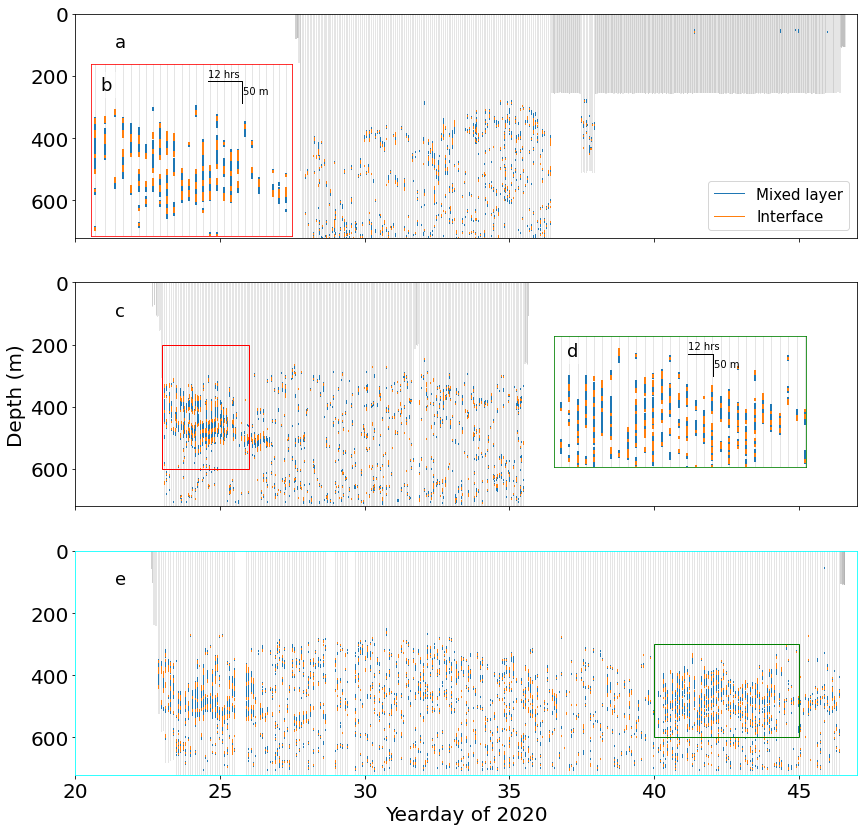

In [23]:
figa, axa = plt.subplots(3,1, figsize=(14,14), sharex='col', sharey=True)
for i, dive in enumerate(glider_df.dive_limb_dec.unique()):
    if dive>2000:
        ax = axa[2]
    elif dive<1000:
        ax = axa[0]
    else:
        ax = axa[1]
    df = df_glider_1m_both.loc[df_glider_1m_both.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax.plot(y, df.p, color='gray', alpha=0.2)
    ax.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='C0')
    ax.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='C1')

axa[0].plot((-1,-1), (-1,-1), color='C0', label='Mixed layer')
axa[0].plot((-1,-1), (-1,-1), color='C1', label='Interface')
axa[0].legend(loc=4)
axa[1].set(ylabel='Depth (m)')
axa[2].set(xlabel='Yearday of 2020', xlim=(20, 47), ylim=(0, 720))
axa[0].invert_yaxis()

ax0 = plt.axes([0.14, 0.66, 0.2, 0.17])

ax1 = plt.axes([0.6, 0.43, 0.25, 0.13])


for i, dive in enumerate(np.arange(1000, 1050)):
    df = df_glider_1m_both.loc[df_glider_1m_both.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax0.plot(y, df.p, color='gray', alpha=0.2)
    ax0.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='C0', linewidth=2)
    ax0.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='C1', linewidth=2)
ax0.set(xlim=(23, 26), ylim=(200, 600), xticks=[], yticks=[])
ax0.invert_yaxis()

for i, dive in enumerate(np.arange(2080, 2150)):
    df = df_glider_1m_both.loc[df_glider_1m_both.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax1.plot(y, df.p, color='gray', alpha=0.2)
    ax1.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='C0', linewidth=2)
    ax1.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='C1', linewidth=2)
ax1.set(xlim=(40, 45), ylim=(300, 600), xticks=[], yticks=[])
ax1.invert_yaxis()


pt=axa[1].add_patch(patches.Rectangle((23,200),3,400,fill=False,zorder=20))
pt.set_ec('red')
pt=axa[2].add_patch(patches.Rectangle((40,300),5,300,fill=False,zorder=20))
pt.set_ec('green')

for child in ax0.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('red')
for child in ax1.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('green')  
for child in axa[2].get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('cyan')          
x, y = 24.75, 240
ax0.plot((x, x+0.5, x+0.5), (y, y, y+50), c='k')
ax0.text(x, y-10, '12 hrs', fontsize=10)
ax0.text(x+0.52, y+30, '50 m', fontsize=10)
x, y = 42.65, 340
ax1.plot((x, x+0.5, x+0.5), (y, y, y+50), c='k')
ax1.text(x, y-10, '12 hrs', fontsize=10)
ax1.text(x+0.52, y+30, '50 m', fontsize=10)   

letterboxes([axa[0], ax0, axa[1], ax1, axa[2]])
savefig('all_gliders_steps')
savefig('fig03b', extension='pdf')

In [41]:
glider_df_mean = glider_df.groupby('dive_limb_dec').mean()
combi_a = glider_df_mean.join(mixes_sum, lsuffix='_glider', rsuffix='_mixes_sum')
combi_b = combi_a.join(mixes_mean, lsuffix='_mixes_sum', rsuffix='_mixes_mean')
combi_c = combi_b.join(grads_sum, lsuffix='_mixes_mean', rsuffix='_grads_sum')
combi_df = combi_c.join(grads_mean, lsuffix='_grads_sum', rsuffix='_grads_mean')
sg637_df = combi_df.loc[combi_df.index>2000]
sg620_df = combi_df.loc[(combi_df.index<2000) & (combi_df.index>1000)]

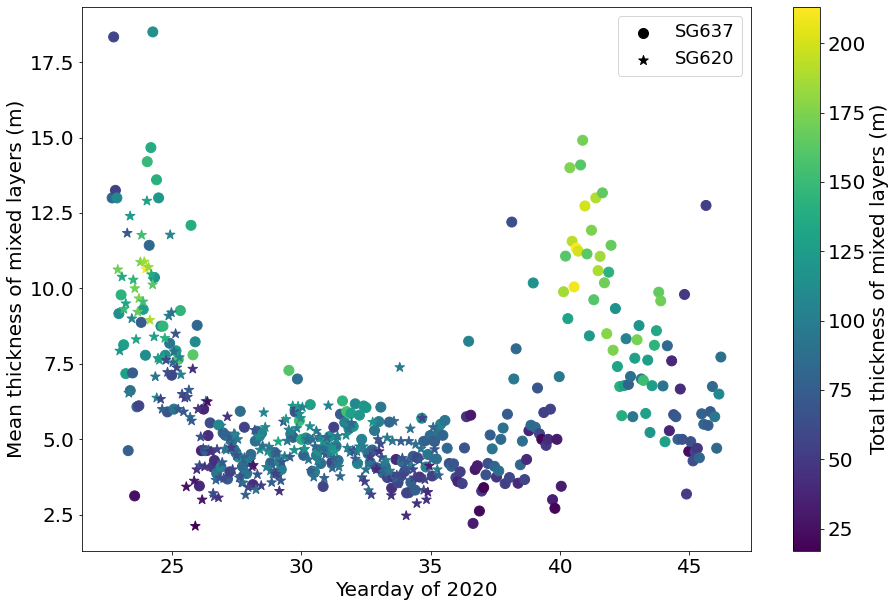

In [42]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(sg637_df.time_yday_local.values[0], sg637_df.layer_height_mixes_mean.values[0], color='k', label='SG637')
ax.scatter(sg620_df.time_yday_local.values[0], sg620_df.layer_height_mixes_mean.values[0],  color='k', marker='*', label='SG620')
mp0 = ax.scatter(sg637_df.time_yday_local, sg637_df.layer_height_mixes_mean, c = sg637_df.layer_height_mixes_sum, cmap='viridis')
mp0 = ax.scatter(sg620_df.time_yday_local, sg620_df.layer_height_mixes_mean, c = sg620_df.layer_height_mixes_sum, cmap='viridis', marker='*')

fig.colorbar(mp0, ax=ax, label = 'Total thickness of mixed layers (m)')
ax.set(xlabel='Yearday of 2020', ylabel='Mean thickness of mixed layers (m)')
ax.legend()
plt.legend(fontsize=18) 

savefig('mld_mean_depth')
savefig('fig06', extension='pdf')

In [73]:
dff = df_glider_1m.copy()
df_glider_multiindex = dff.set_index(['p', 'dive'])
ds_glider = xr.Dataset.from_dataframe(df_glider_multiindex)
ds_glider['ones'] = (('p','dive'), np.ones(np.shape(ds_glider.ct)))
ds_glider['ct_var'] = ds_glider.ct - ds_glider.ct.mean(dim='dive')

window = 50
ds_glider['ct_smooth'] = ds_glider.ct.copy()
for i in range(np.size(ds_glider['ct_smooth'],1)):
    ds_glider['ct_smooth'][:,i] = ds_glider.ct[:,i].to_dataframe().rolling(window, center=True).mean().ct.values

ds_glider['ct_dz'] = ds_glider['ct_smooth'].copy()
ds_glider['ct_dz'][0,:] = 0
ds_glider['ct_dz'][1:, :] = ds_glider['ct_smooth'][1:, :].values - ds_glider['ct_smooth'][:-1, :].values

ds_glider['sa_smooth'] = ds_glider.sa.copy()
for i in range(np.size(ds_glider['sa_smooth'],1)):
    ds_glider['sa_smooth'][:,i] = ds_glider.sa[:,i].to_dataframe().rolling(window, center=True).mean().sa.values
ds_glider['sa_dz'] = ds_glider['sa_smooth'].copy()
ds_glider['sa_dz'][0,:] = 0
ds_glider['sa_dz'][1:, :] = ds_glider['sa_smooth'][1:, :].values - ds_glider['sa_smooth'][:-1, :].values


mask = ds_glider.ml_mask_10m_plus.values.copy()
mask[:] = False
mask_angle = mask.copy()
mask_angle[(ds_glider.turner_ang>45) & (ds_glider.turner_ang<90)] = True
ds_glider['turner_angle_mask'] = (('p','dive'), mask_angle)

mask_den_ratio = mask.copy()
mask_den_ratio[(ds_glider.density_ratio>1) & (ds_glider.density_ratio<2.5)] = True
ds_glider['density_ratio_mask'] = (('p','dive'), mask_den_ratio)

mask_temp = mask.copy()
mask_temp[np.abs(ds_glider.ct_dz)<0.05] = True
ds_glider['temperature_mask'] = (('p','dive'), mask_temp)

mask_sal = mask.copy()
mask_sal[np.abs(ds_glider.sa_dz)<0.006] = True
ds_glider['salinity_mask'] = (('p','dive'), mask_gradients)

mask_gradients = mask.copy()
mask_gradients[(np.abs(ds_glider.sa_dz)<0.006) & (np.abs(ds_glider.ct_dz)<0.05)] = True
ds_glider['gradients_mask'] = (('p','dive'), mask_gradients)

combined_mask = mask.copy()
combined_mask[(mask_gradients==True) & (mask_den_ratio==True) & (mask_angle==True)] = True
ds_glider['combined_mask'] = (('p','dive'), combined_mask)



ds_sg579 = ds_glider.loc[dict(dive=slice(0, 1000))]
ds_sg620 = ds_glider.loc[dict(dive=slice(1000, 2000))]
ds_sg637 = ds_glider.loc[dict(dive=slice(2000, 3000))]
ds_sg637['dive'] = ds_sg637.dive - 2000

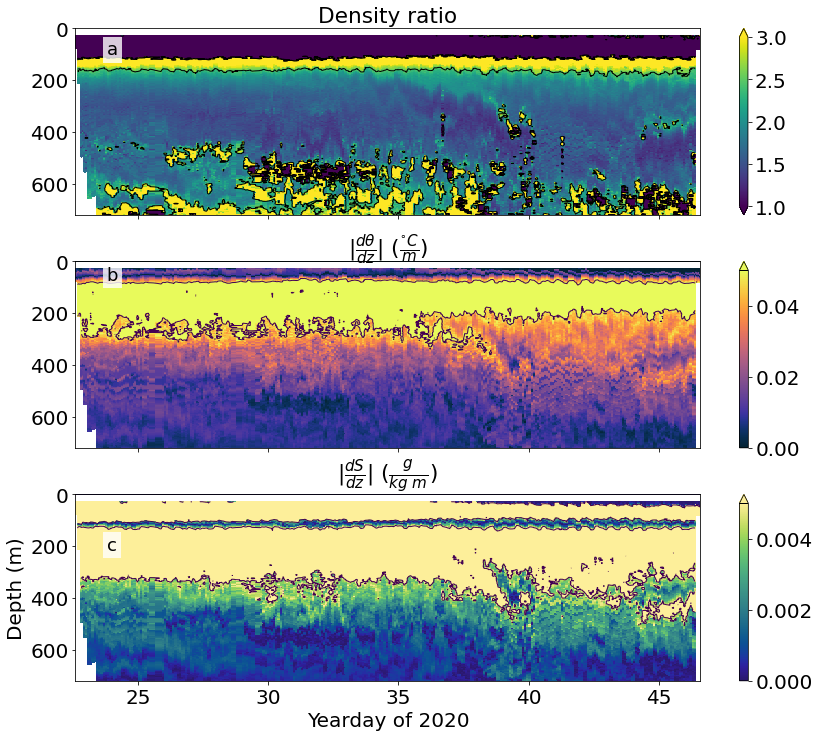

In [78]:
fig, ax = plt.subplots(3,1, figsize=(14,12), sharex=True)
ax = ax.ravel()
plt.subplots_adjust(wspace=0.05, hspace=0.25)

p = ax[0].pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, ds_sg637.density_ratio, cmap='viridis',vmin=1, vmax=3, shading='auto')
ax[0].contour(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, ds_sg637.density_ratio, [2.5], colors='k')
ax[0].contour(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, ds_sg637.density_ratio, [1], colors='k')
ax[0].set_title('Density ratio')

cb1 = fig.colorbar(mappable=p, ax = ax[0], extend='both')
cb1.ax.plot((0,1), (2, 2), color='k')
cb1.ax.plot((0,1), (1, 1), color='white')

p = ax[1].pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.abs(ds_sg637.ct_dz), cmap=cmo.thermal, vmin=0, vmax=0.05, shading='auto')
ax[1].contour(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.abs(ds_sg637.ct_dz),[0.05])
ax[1].set_title('|${\\frac{d \\theta}{dz}}$| $(\\frac{^{\circ}C}{m})$')
cb2 = fig.colorbar(mappable=p, ax = ax[1], extend='max')
cb2.ax.plot((0,1), (0.05, 0.05), color='k')

p = ax[2].pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.abs(ds_sg637.sa_dz), cmap=cmo.haline, vmin=0, vmax=0.005, shading='auto')
ax[2].contour(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.abs(ds_sg637.sa_dz),[0.005])
ax[2].set_title('|${\\frac{dS}{dz}}$| $(\\frac{g}{kg\ m})$')
cb3 = fig.colorbar(mappable=p, ax = ax[2], extend='max')
cb3.ax.plot((0,1), (0.005, 0.005), color='k')
ax[2].set(ylabel='Depth (m)', xlabel='Yearday of 2020')
for axi in ax:
    axi.set(ylim=(0, 720))
    axi.invert_yaxis()
letterboxes(ax, loc=((0.05, 0.86),(0.05, 0.9), (0.05, 0.7)) , box_alpha=0.8)
savefig('fig09', extension='png')


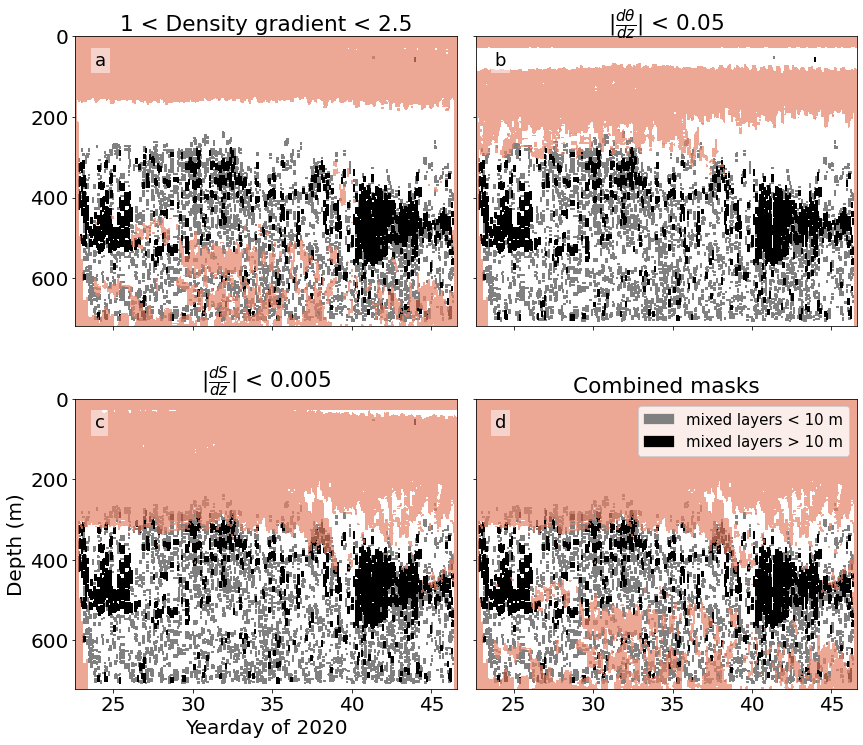

In [77]:
fig, ax = plt.subplots(2,2, figsize=(14,12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.25)

ax = ax.ravel()

ax[0].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.density_ratio_mask)
              , cmap='RdBu', alpha=0.7)
ax[0].set_title('1 < Density gradient < 2.5')

ax[1].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.temperature_mask)
              , cmap='RdBu', alpha=0.7)
ax[1].set_title('|${\\frac{d \\theta }{dz}}$| < 0.05')

ax[2].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.salinity_mask)
              , cmap='RdBu', alpha=0.7)
ax[2].set_title('|${\\frac{dS}{dz}}$| < 0.005')
ax[3].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.combined_mask)
              , cmap='RdBu', alpha=0.7)
ax[3].set_title('Combined masks')
for axa in ax:
    axa.pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.mixed_layer_salt_finger_mask), color='gray', label='mixed layers < 10 m', zorder=-10, shading='auto')
    axa.pcolor(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, np.ma.masked_array(ds_sg637.ones, mask=ds_sg637.ml_mask_10m_plus), color='k', label='mixed layers > 10 m', zorder=-5, shading='auto')
ax[3].legend()
ax[2].set(ylabel='Depth (m)', xlabel='Yearday of 2020')
ax[2].set(ylim=(0, 720))
ax[2].invert_yaxis()
letterboxes(ax, loc=(0.05, 0.9))
savefig('sg637_bitmask_multipanel')
savefig('fig10', extension='pdf')
#savefig('sg637_bitmask_multipanel_notitle')

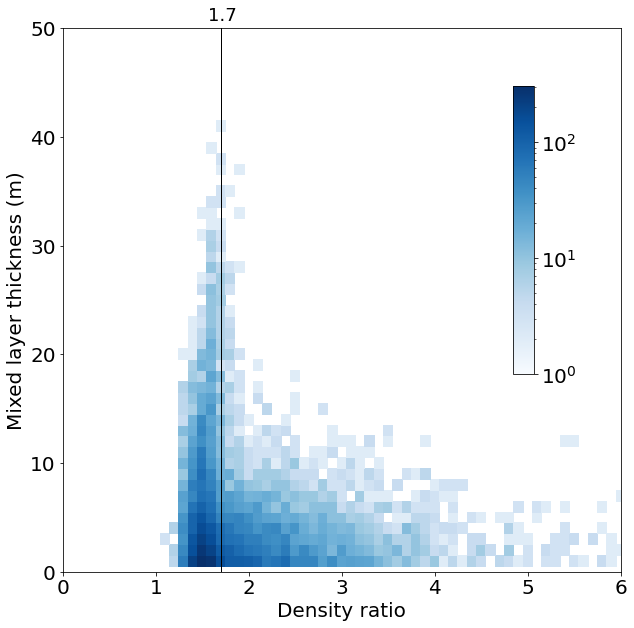

In [46]:
mixes_salt = mixes.loc[(mixes.salt_finger_step) & (mixes.p>100) & (mixes.p<800)]
ratio_step, mld_step = 0.1, 1
ratio_grid = np.arange(0, 10, ratio_step)
mld_grid = np.arange(1, 50, mld_step)
ml_ratio_grid = np.zeros((len(mld_grid), len(ratio_grid)))
for i, t in enumerate(mld_grid):
    for j, s in enumerate(ratio_grid):
        df = mixes_salt.loc[((np.abs(mixes_salt.layer_height - t))<mld_step/2) &
                            ((np.abs(mixes_salt.density_ratio - s))<ratio_step/2)]
        ml_ratio_grid[i, j] = len(df)
ml_ratio_grid[ml_ratio_grid<2] = np.nan  
fig, ax = plt.subplots(figsize=(10,10))
ml_den = ax.pcolor(ratio_grid, mld_grid, ml_ratio_grid,  norm=LogNorm(vmin=1, vmax=np.nanmax(ml_ratio_grid)), shading='auto', cmap='Blues', zorder=-1)
ax.set(xlim=(0,6), xlabel='Density ratio', ylabel='Mixed layer thickness (m)', ylim=(0, 50))
ax.axvline(1.7, color='k')
ax.text(1.56, 50.7, '1.7')
#ax.set_xticks([1,1.7, 2,3,4, 5, 6])
#ax.set_xticklabels([1,1.7, 2,3,4, 5, 6])
sub_ax0 =  plt.axes([0.75, 0.4, 0.03, 0.4])
fig.colorbar(mappable=ml_den, cax=sub_ax0)
savefig('density_ratio_layer_thinkness')
savefig('fig11', extension='pdf')

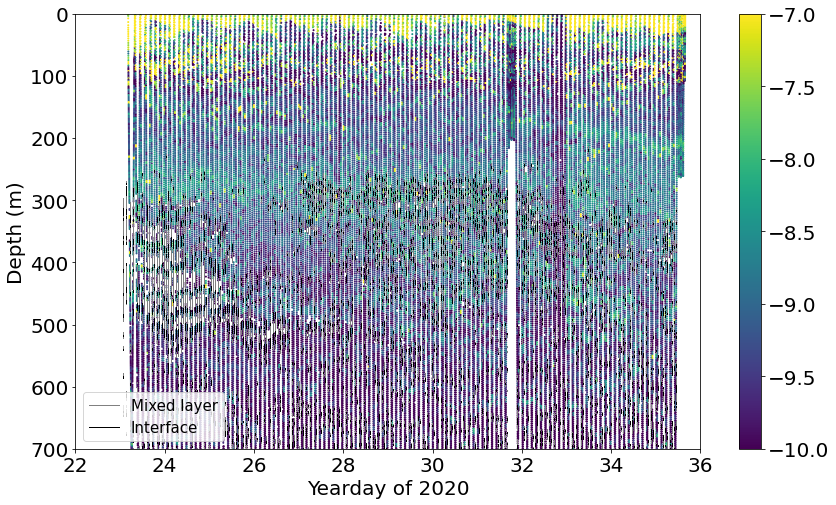

In [47]:
figa, ax = plt.subplots(figsize=(14,8), sharex='col', sharey=True)
mp = ax.scatter(df_dissapation.time_yday_utc, df_dissapation.P, c=df_dissapation.log_eps,  s=1,vmin=-10, vmax=-7, zorder=-10)
for i, dive in enumerate(glider_df.dive_limb_dec.unique()):
    if dive>2000:
        continue
    if dive<1000:
        continue
    df = df_glider_1m.loc[df_glider_1m.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='gray')
    ax.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='k')

ax.plot((-1,-1), (-1,-1), color='gray', label='Mixed layer')
ax.plot((-1,-1), (-1,-1), color='k', label='Interface')
fig.colorbar(mappable=mp, ax = ax)
ax.legend(loc=3)
ax.set(ylabel='Depth (m)')
ax.set(xlabel='Yearday of 2020', xlim=(22, 36), ylim=(0, 700))
ax.invert_yaxis()
savefig('dissapation')

# Meteor compare

In [48]:
dive_df_smooth = df_glider_1m.loc[df_glider_1m.dive==1007, :]

In [49]:
micro_df_dive = df_micro_1m.loc[df_micro_1m.dive == 1007, :].copy()


In [50]:
met_dive_df = ctd_df[ctd_df.cast_no==29]
base = met_dive_df.pressure.max()
base_index = met_dive_df[met_dive_df.pressure==base].index[0]
met_cast_df = met_dive_df[met_dive_df.index<base_index].groupby('depth_bin').median()
dive_df = glider_df[(glider_df['glider']=='sg620') & (glider_df.dive==7)]

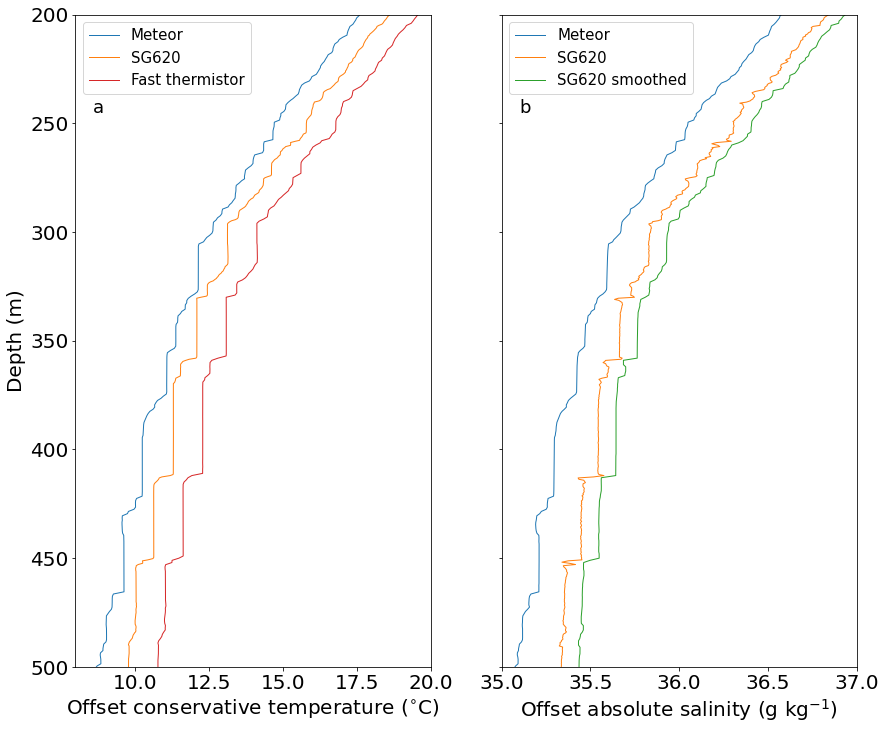

In [51]:
fig, ax = plt.subplots(1,2,figsize=(14,12), sharey='row')

ax[0].plot(met_cast_df.temp, met_cast_df.depth, label='Meteor')
ax[0].plot(dive_df.temp+1, dive_df.depth, label='SG620')
ax[1].plot(met_cast_df.absal, met_cast_df.depth, label='Meteor')
ax[1].plot(dive_df.abs_salinity+0.1, dive_df.depth, label='SG620')
#ax[1].plot(dive_df_smooth.abs_salinity+0.25, dive_df_smooth.depth, label='sg620 smoothed')
ax[1].plot(dive_df_smooth.sa+0.2, dive_df_smooth.p, label='SG620 smoothed')
ax[0].plot(micro_df_dive.ct+2, micro_df_dive.p, label='Fast thermistor', color='C3')

#ax.plot(micro_df_dive.ct+2, micro_df_dive.p, label='Fast thermistor')
ax[0].legend()
ax[1].legend()
ax[0].set(ylabel='Depth (m)', xlabel='Offset conservative temperature ($^{\circ}$C)', xlim=(8, 20), ylim=(200, 500))
ax[1].set(xlabel='Offset absolute salinity (g kg$^{-1}$)', xlim=(35, 37))

ax[0].invert_yaxis()
letterboxes(ax)
savefig('obvs_compare')
savefig('fig07', extension='pdf')

# van der Boog compare

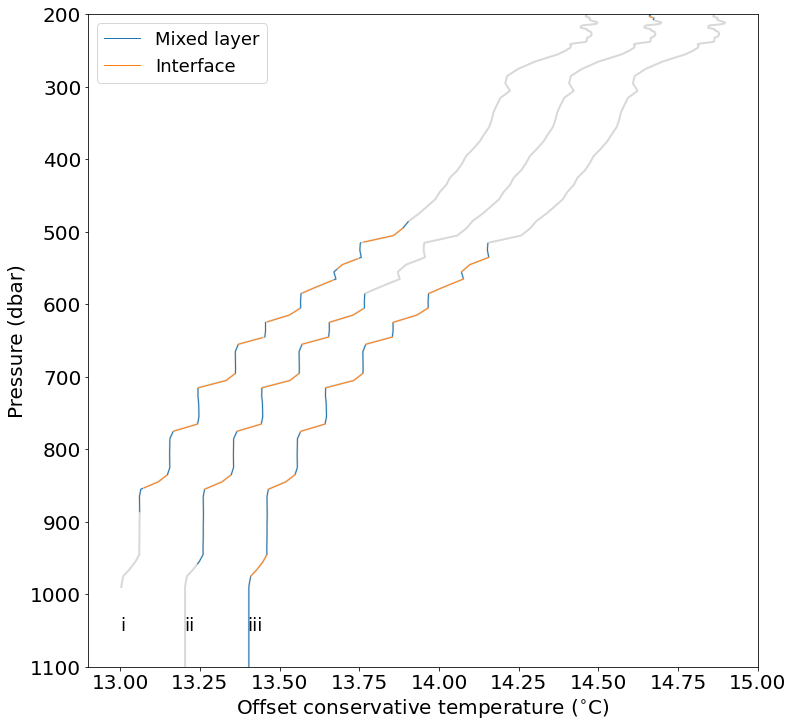

In [92]:
df_callum_argo, mixes_callum_argo, grads_callum_argo = classify_staircase(ds_vdb.pressure.values,
                                                                          ds_vdb.ct.values[0],
                                                                          ds_vdb.sa.values[0])

df_callum_argo_mod, mixes_callum_argo_mod, grads_callum_argo_mod = classify_staircase(ds_vdb.pressure.values,
                                                                          ds_vdb.ct.values[0],
                                                                          ds_vdb.sa.values[0],
                                                                          layer_height_ratio=0.9,
                                                                          ml_density_difference=0.001, ml_grad=0.00025 )



fig, ax = plt.subplots(figsize=(12,12))
offset=0.2
ax.plot(ds_vdb.ct[0, :], ds_vdb.pressure, color='gray', alpha=0.3, linewidth=2)
ax.plot(ds_vdb.ct[0,:] * ds_vdb.mask_ml_sf[0,:] / ds_vdb.mask_ml_sf[0,:], ds_vdb.pressure, color='C0', label='Mixed layer')
ax.plot(ds_vdb.ct[0,:] * ds_vdb.mask_gl_sf[0,:] / ds_vdb.mask_gl_sf[0,:], ds_vdb.pressure, color='C1', label='Interface')
ax.plot(df_callum_argo.ct + offset, df_callum_argo.p, color='gray', alpha=0.3, linewidth=2)
ax.plot(df_callum_argo.ct + offset*2, df_callum_argo.p, color='gray', alpha=0.3, linewidth=2)
ax.plot(np.ma.array(df_callum_argo.ct, mask=df_callum_argo['mixed_layer_final_mask']) + offset, df_callum_argo.p, color='C0')
ax.plot(np.ma.array(df_callum_argo.ct, mask=df_callum_argo['gradient_layer_final_mask']) + offset, df_callum_argo.p, color='C1')
ax.plot(np.ma.array(df_callum_argo_mod.ct, mask=df_callum_argo_mod['mixed_layer_final_mask']) + offset*2, df_callum_argo_mod.p, color='C0')
ax.plot(np.ma.array(df_callum_argo_mod.ct, mask=df_callum_argo_mod['gradient_layer_final_mask']) + offset*2, df_callum_argo_mod.p, color='C1')
ax.set(xlim=(12.9, 15), ylim=(200, 1100), xlabel='Offset conservative temperature ($^{\circ}$C)', ylabel='Pressure (dbar)')
ax.legend()
plt.legend(fontsize=18) 
ax.text(13, 1050, 'i')
ax.text(13.2, 1050, 'ii')
ax.text(13.4, 1050, 'iii')
ax.invert_yaxis()
savefig('vdb_argo_comparison')
savefig('fig05', extension='pdf')

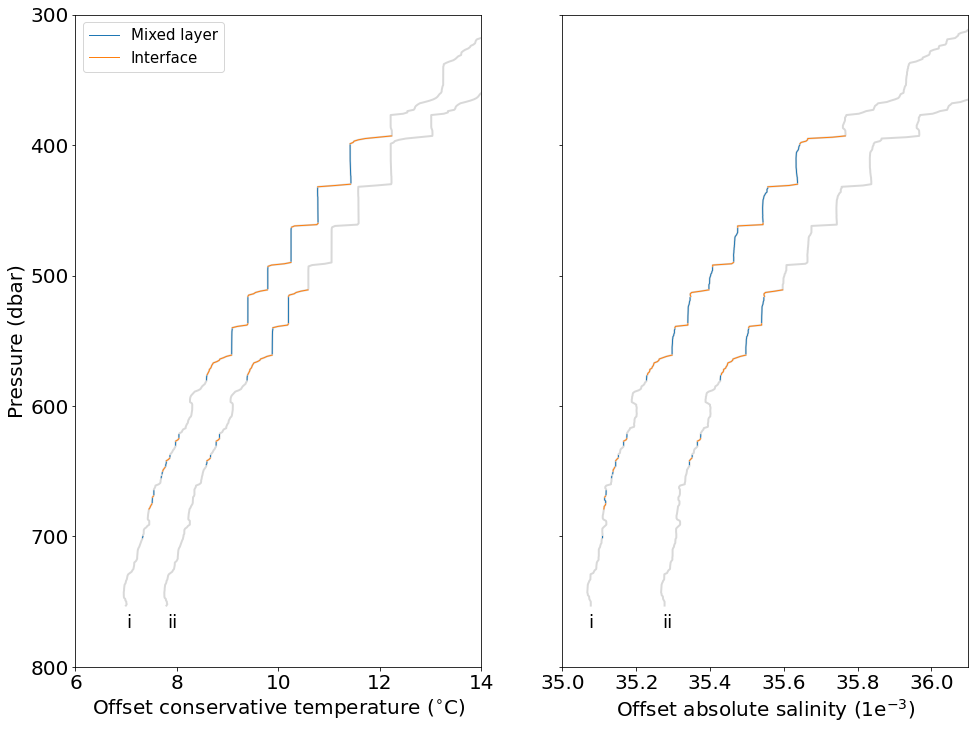

In [110]:
key_dive=2119
#key_dive=2120

df_callum_argo = df_glider_1m.loc[df_glider_1m.dive==key_dive, :]
df_callum_argo_mod = df_glider_1m_both.loc[df_glider_1m_both.dive==key_dive, :]
fig, [ax, ax1] = plt.subplots(1,2, figsize=(16,12), sharey=True)
offset=0.8
ax.plot(ds_vdb.ct[0,:] * ds_vdb.mask_ml_sf[0,:] / ds_vdb.mask_ml_sf[0,:], ds_vdb.pressure + 1000, color='C0', label='Mixed layer')
ax.plot(ds_vdb.ct[0,:] * ds_vdb.mask_gl_sf[0,:] / ds_vdb.mask_gl_sf[0,:], ds_vdb.pressure + 1000, color='C1', label='Interface')
ax.plot(df_callum_argo.ct + offset, df_callum_argo.p, color='gray', alpha=0.3, linewidth=2)
ax.plot(df_callum_argo.ct + offset*2, df_callum_argo.p, color='gray', alpha=0.3, linewidth=2)
ax.plot(np.ma.array(df_callum_argo.ct, mask=df_callum_argo['mixed_layer_salt_finger_mask']) + offset, df_callum_argo.p, color='C0')
ax.plot(np.ma.array(df_callum_argo.ct, mask=df_callum_argo['gradient_layer_final_mask']) + offset, df_callum_argo.p, color='C1')
ax.plot(np.ma.array(df_callum_argo_mod.ct, mask=df_callum_argo_mod['mixed_layer_salt_finger_mask']) + offset*2, df_callum_argo_mod.p, color='C0')
ax.plot(np.ma.array(df_callum_argo_mod.ct, mask=df_callum_argo_mod['gradient_layer_final_mask']) + offset*2, df_callum_argo_mod.p, color='C1')
ax.set(xlim=(6, 14), ylim=(300, 800), xlabel='Offset conservative temperature ($^{\circ}$C)', ylabel='Pressure (dbar)')

offset=0.2

ax1.plot(df_callum_argo.sa + offset, df_callum_argo.p, color='gray', alpha=0.3, linewidth=2)
ax1.plot(df_callum_argo.sa + offset*2, df_callum_argo.p, color='gray', alpha=0.3, linewidth=2)
ax1.plot(np.ma.array(df_callum_argo.sa, mask=df_callum_argo['mixed_layer_final_mask']) + offset, df_callum_argo.p, color='C0')
ax1.plot(np.ma.array(df_callum_argo.sa, mask=df_callum_argo['gradient_layer_final_mask']) + offset, df_callum_argo.p, color='C1')
ax1.plot(np.ma.array(df_callum_argo_mod.sa, mask=df_callum_argo_mod['mixed_layer_final_mask']) + offset*2, df_callum_argo_mod.p, color='C0')
ax1.plot(np.ma.array(df_callum_argo_mod.sa, mask=df_callum_argo_mod['gradient_layer_final_mask']) + offset*2, df_callum_argo_mod.p, color='C1')
ax1.set(xlim=(35, 36.1), xlabel='Offset absolute salinity (1e$^{-3}$)')


ax.legend()
ax.text(7, 770, 'i')
ax.text(7.8, 770, 'ii')
ax1.text(35.07, 770, 'i')
ax1.text(35.27, 770, 'ii')
ax.invert_yaxis()
savefig('fig05b', extension='pdf')

In [ ]:
for i, dive in enumerate(np.arange(2080, 2150)):
    df = df_glider_1m_both.loc[df_glider_1m_both.dive == dive, :]
    offset = df.time_yday_utc.mean()
    y = np.ones(len(df.ct)) * offset
    ax1.plot(y, df.p, color='gray', alpha=0.2)
    ax1.plot(np.ma.array(y, mask=df['mixed_layer_final_mask']) , np.ma.array(df.p, mask=df['mixed_layer_final_mask']), color='C0', linewidth=2)
    ax1.plot(np.ma.array(y, mask=df['gradient_layer_final_mask']), np.ma.array(df.p, mask=df['gradient_layer_final_mask']), color='C1', linewidth=2)

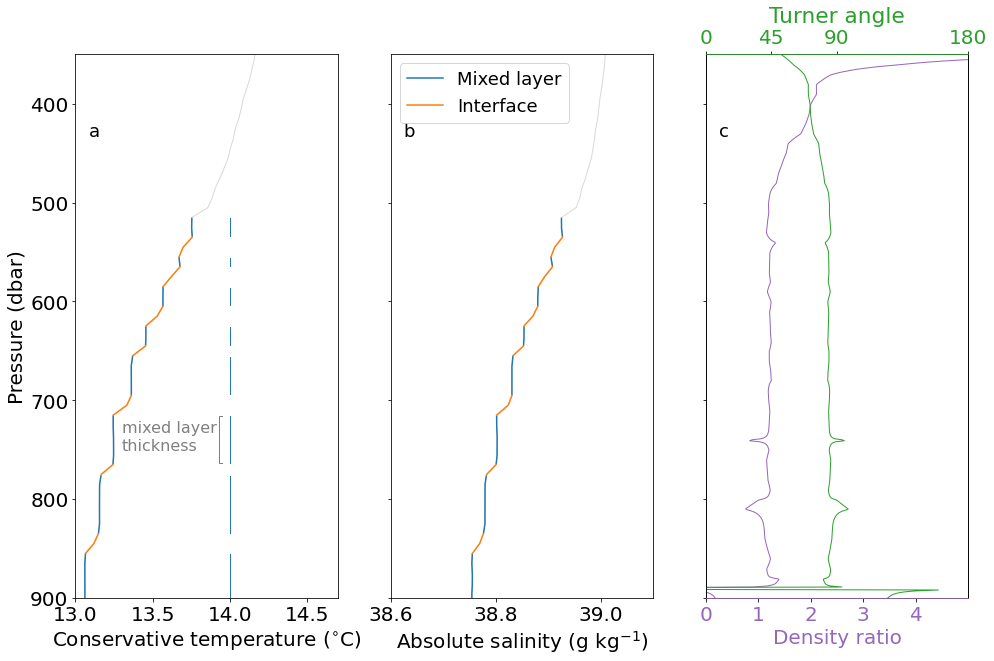

In [53]:
fig, ax = plt.subplots(1,3, sharey='row', figsize=(16,10))
lw = 1.5
ax = ax.ravel()
ax[0].plot(df_callum_argo.ct, df_callum_argo.p, color='gray', alpha=0.3)
ax[0].plot(np.ma.array(df_callum_argo_mod.ct, mask=df_callum_argo_mod['mixed_layer_final_mask']) , df_callum_argo_mod.p, color='C0', label='Mixed layer', linewidth=lw)
ax[0].plot(np.ma.array(df_callum_argo_mod.ct, mask=df_callum_argo_mod['gradient_layer_final_mask']), df_callum_argo_mod.p, color='C1', label='Interface', linewidth=lw)
ax[1].plot(df_callum_argo.sa, df_callum_argo.p, color='gray', alpha=0.3)
ax[1].plot(np.ma.array(df_callum_argo_mod.sa, mask=df_callum_argo_mod['mixed_layer_final_mask']) , df_callum_argo_mod.p, color='C0', label='Mixed layer', linewidth=lw)
ax[1].plot(np.ma.array(df_callum_argo_mod.sa, mask=df_callum_argo_mod['gradient_layer_final_mask']), df_callum_argo_mod.p, color='C1', label='Interface', linewidth=lw)

ax[2].plot(df_callum_argo_mod.density_ratio, df_callum_argo_mod.p, color='C4')
ax[2].set_title('Turner angle', c='C2')
ax[2].set(xlim=(0,5), xlabel='Density ratio', xticks=[0,1,2,3,4])
ax[2].set_xticklabels([0,1, 2,3,4], color='C4')
ax[2].xaxis.label.set_color('C4')

ax1 = ax[2].twiny()
ax1.plot(np.arange(0, 181), np.ones(181)*100) 
ax1.set(xlim=(0,180), xticks=[0, 45, 90, 180])

ax1.plot(df_callum_argo_mod.turner_ang, df_callum_argo_mod.p, c='C2')
ax1.spines['top'].set_color('C2') 
ax1.spines['bottom'].set_color('C4') 

ax1.set_xticklabels([0, 45, 90, 180], color='C2')
ax[0].set(xlim=(13, 14.7), ylim=(350, 900), xlabel=labels['temp'], ylabel='Pressure (dbar)')
ax[1].set(xlabel=labels['sal'], xlim=(38.6, 39.1))
ax[1].legend()
ax[1].legend(fontsize=18) 
ax[0].invert_yaxis()

mix_x = 14
for i, mix in mixes_callum_argo_mod.iterrows():
    ax[0].plot([mix_x, mix_x], [mix.p_start, mix.p_end], color='C0')
ax[0].text(13.3, 750, "mixed layer\nthickness", fontsize=16, color='gray')
#ax[0].text(14.07, 680, "$\\Sigma$ =", fontsize=14, color='k')
#ax[0].text(14.2, 700, "total\nthickness\nof mixed\nlayers", fontsize=16, color='k')
#ax[0].plot([14.03, 14.05, 14.05, 14.03], [899, 899, 486, 486], color='k')
ax[0].plot([13.95, 13.93, 13.93, 13.95], [716, 716, 764, 764], color='gray')
letterboxes(ax)

savefig('fig01', extension='pdf')

# Shader

In [54]:
gsub = glider_df.loc[(glider_df.glider=='sg637') &(glider_df.direction==-1.0)]
gsub_mean = gsub.groupby('depth_bin').mean()
gsub_var = gsub[['cons_temp', 'depth', 'depth_bin', 'abs_salinity', 'sigma0']]
gsub_std = gsub_var.groupby('depth_bin').std()
gav_sub = glider_av_df.loc[(glider_av_df.dive_limb_ident>2000) &(glider_av_df.direction==-1.0)]
gav_sub['day'] = np.floor(gav_sub.time_yday_local)
gav_day = gav_sub.groupby('day').mean()

/tmp/ipykernel_4234/3997225421.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gav_sub['day'] = np.floor(gav_sub.time_yday_local)


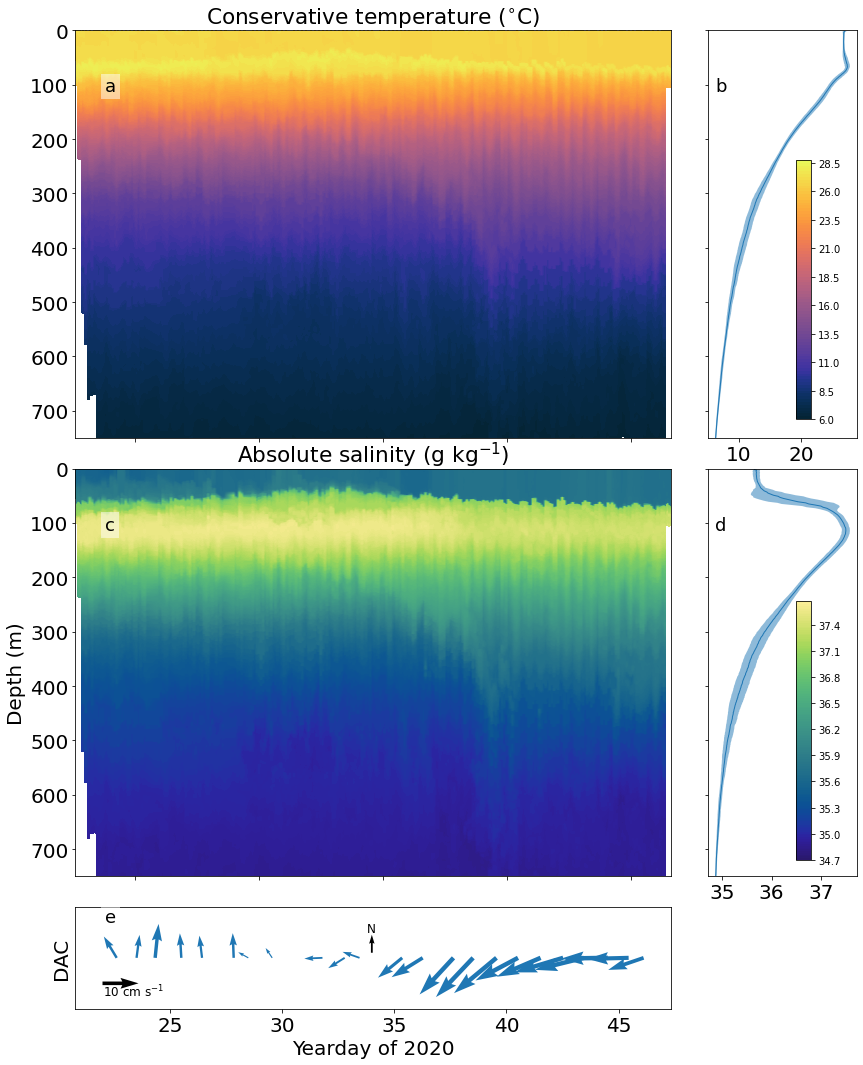

In [55]:
fig, ax = plt.subplots(3,2, figsize=(14,18),sharey="row",
    gridspec_kw={"height_ratios": [2,2,0.5], "width_ratios": [4, 1]})

fig.subplots_adjust(hspace=0.1, wspace=0.1)
ax = ax.ravel()
kwargs = {'cmap':cmo.thermal}
mp0 = ax[0].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, ds_sg637.ct,np.arange(6, 29, 0.25),**kwargs)
#ax[0].contour(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, colors='k')
ax[1].plot(gsub_mean.cons_temp, gsub_mean.depth)
ax[1].fill_betweenx(gsub_mean.depth, gsub_mean.cons_temp-gsub_std.cons_temp, 
                  gsub_mean.cons_temp+gsub_std.cons_temp, alpha=0.5)
ax[0].set(xticklabels=[], title=labels['temp'], ylim=[0, 750])
sub_ax0 =  plt.axes([0.84, 0.58, 0.015, 0.2])
cbar0 = fig.colorbar(mappable=mp0, cax=sub_ax0)
cbar0.ax.tick_params(labelsize=10)

mp1 = ax[2].contourf(ds_sg637.time_yday_utc.mean(dim='p').values, ds_sg637.p, ds_sg637.sa,np.arange(34.7, 37.7, 0.02), cmap=cmo.haline)
#ax[2].contour(x,-y,pden, colors='k')
ax[2].set(xticklabels=[], ylabel='Depth (m)', title=labels['sal'], ylim=[0, 750])

ax[3].plot(gsub_mean.abs_salinity, gsub_mean.depth)
ax[3].fill_betweenx(gsub_mean.depth, gsub_mean.abs_salinity-gsub_std.abs_salinity, 
                  gsub_mean.abs_salinity+gsub_std.abs_salinity, alpha=0.5)
sub_ax1 =  plt.axes([0.84, 0.24, 0.015, 0.2])
cbar1 = fig.colorbar(mappable=mp1, cax=sub_ax1)
cbar1.ax.tick_params(labelsize=10)


ax[4].quiver(gav_day.time_yday_local, np.zeros(len(gav_day.x)), gav_day.DAC_u, gav_day.DAC_v, scale=0.2, scale_units='inches', minlength=2, minshaft=2, color='C0')
ax[4].quiver([22, 34], [-0.1, 0.02], [0.1, 0],[0, 0.05], scale=0.2, scale_units='inches', minlength=2, minshaft=2)
ax[4].text(22, -0.15, "10 $\mathrm{cm\ s^{-1}}$", fontsize=12)
ax[4].text(33.8,0.1, "N", fontsize=12)

ax[4].set(ylim=[-0.2, 0.2], xlabel='Yearday of 2020', yticks=[], ylabel='DAC')
ax[5].axis('off')
ax[0].invert_yaxis()
ax[2].invert_yaxis()
letterboxes(ax[:5])
savefig('shader')
savefig('fig08', extension='png')

# Fast thermistor scaling

In [56]:
from detect_staircases import classify_staircase
from data_prep import glider_df
glider_df['dive_limb_dec'] = glider_df.dive_limb_ident - glider_df.dive + glider_df.dive_num

In [57]:
micro_df = pd.read_csv('data/micro_cor_subsamp16.csv')
micro_df['dive_limb_dec'] = micro_df['dive_num'] + 1000
micro_df['dive_limb_ident'] = np.floor(micro_df['dive_num']) + 1000

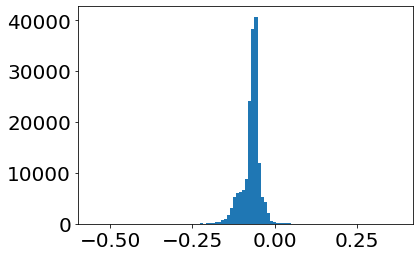

In [58]:
micro_df_1m = pd.DataFrame()
for i, dive in enumerate(micro_df.dive_limb_dec.unique()):
    df_dive = micro_df.loc[micro_df.dive_limb_dec == dive, :].copy()
    df_dive['depth_1m'] = df_dive['depth']
    df_dive = df_dive.astype({'depth_1m': 'int32'})
    df_dive['dive_depth_ident'] = df_dive.dive_limb_dec*10000 + df_dive.depth_1m
    df_1db = df_dive.groupby('depth_1m', as_index=False).median()
    micro_df_1m = micro_df_1m.append(df_1db)
    
melon_df = glider_df[glider_df.glider=='sg620']
melon_df_1m = pd.DataFrame()
for i, dive in enumerate(melon_df.dive_limb_dec.unique()):
    df_dive = melon_df.loc[melon_df.dive_limb_dec == dive, :].copy()
    df_dive['depth_1m'] = df_dive['depth']
    df_dive = df_dive.astype({'depth_1m': 'int32'})
    df_dive['dive_depth_ident'] = df_dive.dive_limb_dec*10000 + df_dive.depth_1m
    df_1db = df_dive.groupby('depth_1m', as_index=False).median()
    melon_df_1m = melon_df_1m.append(df_1db)
    
melon_df_1m = melon_df_1m.astype({'dive_depth_ident': 'int32'})
melon_df_1m.index = melon_df_1m.dive_depth_ident

micro_df_1m = micro_df_1m.astype({'dive_depth_ident': 'int32'})
micro_df_1m.index = micro_df_1m.dive_depth_ident

combi_df_1m = micro_df_1m.join(melon_df_1m, rsuffix='_glider', lsuffix='_micro')

plt.hist(combi_df_1m.cons_temp - combi_df_1m.temp_corr, 100);

In [59]:
micro_df['dive_depth_ident'] = micro_df.dive_limb_dec*10000 + micro_df.depth
micro_df_sub = micro_df[(micro_df.dive_limb_dec>1010) & (micro_df.dive_limb_dec<1220)]
melon_df['dive_depth_ident'] = melon_df.dive_limb_dec*10000 + melon_df.depth
melon_df_sub = melon_df[(melon_df.dive_limb_dec>1010) & (melon_df.dive_limb_dec<1220)]
micro_df_sub = micro_df_sub.sort_values('dive_depth_ident')
melon_df_sub = melon_df_sub.sort_values('dive_depth_ident')
micro_sal = pd.merge_asof(micro_df_sub, melon_df_sub, direction='nearest', on='dive_depth_ident', suffixes=('_micro', 'glider'))
micro_essential = pd.DataFrame({'dive_depth_ident': micro_sal.dive_depth_ident,
                                'dive_limb_dec': micro_sal.dive_limb_dec_micro,
                                'depth': micro_sal.depth_micro,
                                'ct': micro_sal.temp_micro,
                                'sa': micro_sal.abs_salinity})

/tmp/ipykernel_4234/2058095879.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  melon_df['dive_depth_ident'] = melon_df.dive_limb_dec*10000 + melon_df.depth


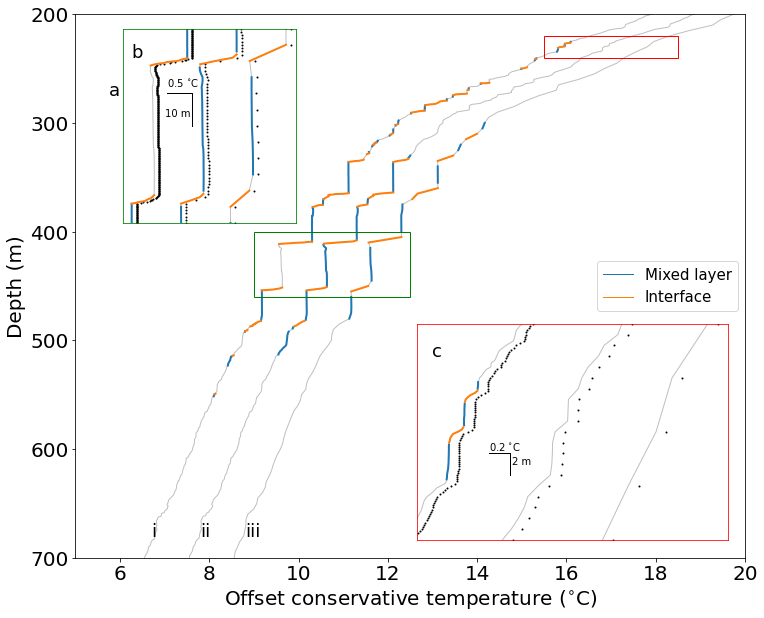

In [60]:
mixes = pd.DataFrame()
df_sel = micro_essential.loc[micro_essential.dive_limb_dec == 1010.5, :].copy()

figa, ax = plt.subplots(figsize=(12, 10))
ax0 = plt.axes([0.52, 0.15, 0.36, 0.3])
ax1 = plt.axes([0.18, 0.59, 0.2, 0.27])

factors=[0.2, 1, 5]
for i, factor in enumerate(factors):
    df_dive = df_sel.copy()
    df_dive['depth_scale'] = df_dive.depth/factor
    df_dive['depth_1m'] = df_dive.depth_scale.astype(int)
    df_dive = df_dive.groupby('depth_1m', as_index=False).median()
    new_index = pd.Index(np.arange(0, df_dive.depth_1m.max(), 1), name="depth_1m")
    df_1db = df_dive.set_index("depth_1m").reindex(new_index)
    df_1db['depth_true'] = df_1db.index*factor
    df_1db
    #print(int(len(df_sel.loc[df_sel.dive_limb_dec == dive, :])/len(df_dive)))
    df, df_ml_stats, df_gl_stats = classify_staircase(df_1db.depth_true, df_1db.ct, df_1db.sa,
                                              ml_grad=0.005, ml_density_difference=0.05, av_window=100,
                                              interface_max_height=30, temp_flag_only=True, show_steps=False)
    offset = i * 1
    ax0.scatter(df_1db.ct + offset+0.1, df_1db.depth_true, color='k', s=1)
    ax1.scatter(df_1db.ct + offset+0.1, df_1db.depth_true, color='k', s=1)
    for axa in [ax0, ax1, ax]:
        axa.plot(df_1db.ct + offset, df_1db.depth_true, color='gray', alpha=0.5)
        axa.plot(np.ma.array(df.ct, mask=df['mixed_layer_final_mask']) + offset, df.p, color='C0', linewidth=2)
        axa.plot(np.ma.array(df.ct, mask=df['gradient_layer_final_mask']) + offset,df.p, color='C1', linewidth=2)

axa.plot((-1,-1), (-1,-1), color='C0', label='Mixed layer')
axa.plot((-1,-1), (-1,-1), color='C1', label='Interface')


ax0.set(xlim=(15.5, 18.5), ylim=(220, 240), xticks=[], yticks=[])
ax0.invert_yaxis()
pt=axa.add_patch(patches.Rectangle((15.5,220),3,20,fill=False,zorder=20))
pt.set_ec('red')
for child in ax0.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('red')

        
ax1.set(xlim=(9, 12.5), ylim=(400, 460), xticks=[], yticks=[])
ax1.invert_yaxis()
pt=axa.add_patch(patches.Rectangle((9,400),3.5,60,fill=False,zorder=20))
pt.set_ec('green')
for child in ax1.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('green')

        
x, y = 16.2, 232
ax0.plot((x, x+0.2, x+0.2), (y, y, y+2), c='k')
ax0.text(x, y-0.3, '0.2 $^{\circ}$C', fontsize=10)
ax0.text(x+0.22, y+1, '2 m', fontsize=10)

x, y = 9.9, 420
ax1.plot((x, x+0.5, x+0.5), (y, y, y+10), c='k')
ax1.text(x, y-2, '0.5 $^{\circ}$C', fontsize=10)
ax1.text(x-0.05, y+7, '10 m', fontsize=10)
        
axa.legend(loc=5)
#axa.legend(fontsize=18) 

axa.set(ylim=(200, 700), xlim=(5, 20), xlabel='Offset conservative temperature ($^{\circ}$C)', ylabel='Depth (m)')
#axa.set(ylim=(150, 400), xlim=(12, 18))
#axa.set(ylabel='Pressure (dbar)', xlabel='Offset conservative temperature', ylim=(250, 600), xlim=(6, 25))
axa.invert_yaxis()
letterboxes([axa, ax1, ax0])
axa.text(6.7, 680, 'i')
axa.text(7.8, 680, 'ii')
axa.text(8.8, 680, 'iii')

savefig('fast_thermistor_examples')
savefig('fig12', extension='pdf')

In [61]:
mixes = pd.DataFrame()
factors=[0.2, 1, 5]
mixes = [pd.DataFrame(), pd.DataFrame(), pd.DataFrame()]
for facn, factor in enumerate(factors):
    df_sel = micro_essential
    df_out = pd.DataFrame()
    for i, dive in enumerate(df_sel.dive_limb_dec.unique()):
        
        df_dive = df_sel.loc[df_sel.dive_limb_dec == dive, :].copy()
        df_dive['depth_scale'] = df_dive.depth/factor
        df_dive['depth_1m'] = df_dive.depth_scale.astype(int)
        df_dive = df_dive.groupby('depth_1m', as_index=False).median()
        new_index = pd.Index(np.arange(0, df_dive.depth_1m.max(), 1), name="depth_1m")
        df_1db = df_dive.set_index("depth_1m").reindex(new_index)
        df_1db['depth_true'] = df_1db.index*factor
        df_1db
        df, df_ml_stats, df_gl_stats = classify_staircase(df_1db.depth_true, df_1db.ct, df_1db.sa,
                                                  ml_grad=0.005, ml_density_difference=0.05, av_window=100,
                                                  interface_max_height=30, temp_flag_only=True, show_steps=False)
        mixes[facn] = mixes[facn].append(df_ml_stats)

In [62]:
mix_master = pd.DataFrame()
scales = ['0.2 m', '1 m', '5 m']
for i, mix in enumerate(mixes):
    mix["scale"] = scales[i]
    mix_master = mix_master.append(mix)
mixes_salt = mix_master.loc[(mix_master.salt_finger_step) & (mix_master.p>100) & (mix_master.p<800)]

In [63]:
short = mixes_salt[mixes_salt.scale=="0.2 m"]
short_heights, height_edges = np.histogram(short.layer_height, bins=np.arange(0, 55, 2))
short_depths, depth_edges = np.histogram(short.p, bins=np.arange(100, 810, 20))

mid = mixes_salt[mixes_salt.scale=="1 m"]
mid_heights, height_edges = np.histogram(mid.layer_height, bins=np.arange(0, 55, 2))
mid_depths, depth_edges = np.histogram(mid.p, bins=np.arange(100, 810, 20))

tall = mixes_salt[mixes_salt.scale=="5 m"]
tall_heights, height_edges = np.histogram(tall.layer_height, bins=np.arange(0, 55, 2))
tall_depths, depth_edges = np.histogram(tall.p, bins=np.arange(100, 810, 20))

height_centres = edge_to_centre(height_edges)
depth_centres = edge_to_centre(depth_edges)


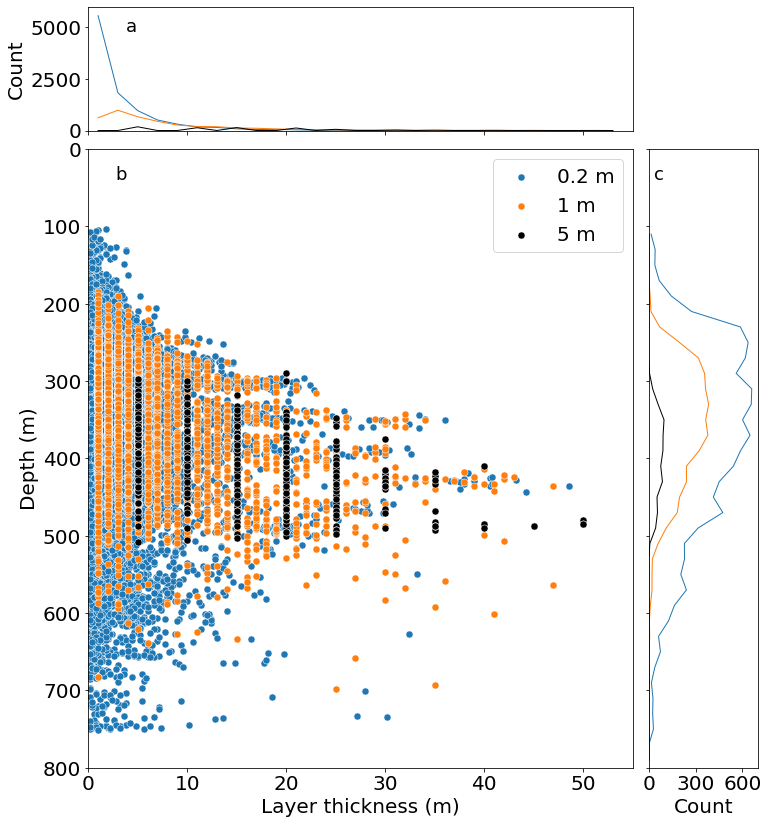

In [64]:
fig, ax = plt.subplots(2,2, figsize=(12,14), gridspec_kw={'width_ratios': [5, 1], 'height_ratios': [1, 5]}, sharey='row', sharex='col')
plt.subplots_adjust(wspace=0.05, hspace=0.05)
ax = ax.ravel()
kwarg = {'s':50, 'edgecolors':'white', 'linewidths':0.5}
ax[0].plot(height_centres, short_heights)
ax[3].plot(short_depths, depth_centres)
ax[2].scatter(short.layer_height, short.p, **kwarg, label='0.2 m')

ax[0].plot(height_centres, mid_heights)
ax[3].plot(mid_depths, depth_centres)
ax[2].scatter(mid.layer_height, mid.p, **kwarg, label='1 m')

ax[0].plot(height_centres, tall_heights, color="k")
ax[3].plot(tall_depths, depth_centres, color="k")
ax[2].scatter(tall.layer_height, tall.p, **kwarg, label='5 m', color='k')
ax[2].legend(title='Scale')
ax[2].legend(fontsize=20) 

ax[0].set(ylim=(0, 6000), ylabel='Count', yticks=[0, 2500, 5000])
ax[3].set(xlim=(0, 700), xlabel='Count', xticks=[0, 300, 600])
ax[2].set(xlim=(0, 55), ylim=(0, 800), xlabel='Layer thickness (m)', ylabel='Depth (m)')
ax[2].invert_yaxis()
fig.delaxes(ax[1])
letterboxes([ax[0], ax[2], ax[3]], loc=[[0.07, 0.8], [0.05, 0.95], [0.05, 0.95]])
savefig('scale_analysis')
savefig('fig13', extension='pdf')

[Text(1.0, 0, '1'),
 Text(1.7, 0, '1.7'),
 Text(2.0, 0, '2'),
 Text(3.0, 0, '3'),
 Text(4.0, 0, '4'),
 Text(5.0, 0, '5'),
 Text(6.0, 0, '6')]

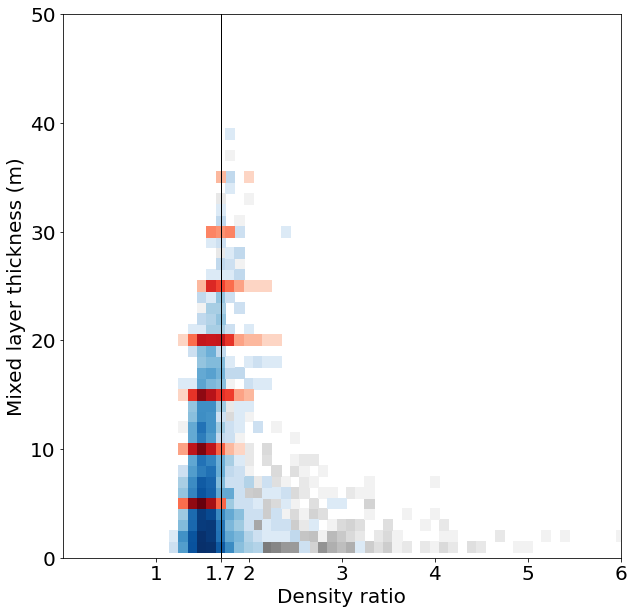

In [65]:
cmaps = ['Greys', 'Blues', 'Reds']
fig, ax = plt.subplots(figsize=(10,10))
for n in range(3):
    mixes_salt = mixes[n].loc[(mixes[n].salt_finger_step) & (mixes[n].p>100) & (mixes[n].p<800)]
    ratio_step, mld_step = 0.1, 1
    ratio_grid = np.arange(0, 10, ratio_step)
    mld_grid = np.arange(1, 50, mld_step)
    ml_ratio_grid = np.zeros((len(mld_grid), len(ratio_grid)))
    for i, t in enumerate(mld_grid):
        for j, s in enumerate(ratio_grid):
            df = mixes_salt.loc[((np.abs(mixes_salt.layer_height - t))<mld_step/2) &
                                ((np.abs(mixes_salt.density_ratio - s))<ratio_step/2)]
            ml_ratio_grid[i, j] = len(df)
    ml_ratio_grid[ml_ratio_grid<2] = np.nan  
    ax.pcolor(ratio_grid, mld_grid, ml_ratio_grid,  norm=LogNorm(vmin=1, vmax=np.nanmax(ml_ratio_grid)), shading='auto', cmap=cmaps[n])
ax.set(xlim=(0,6), xlabel='Density ratio', ylabel='Mixed layer thickness (m)', ylim=(0, 50))
ax.axvline(1.7, color='k', zorder=5)
ax.set_xticks([1,1.7, 2,3,4, 5, 6])
ax.set_xticklabels([1,1.7, 2,3,4, 5, 6])

#savefig('density_ratio_layer_thinkness')

# Experiment

In [ ]:
def vanderboog_stats(df_mix, df_grad, min_per=0.025, max_per=0.975):
    p_min = df_mix.p_start.quantile(min_per)
    p_max = df_mix.p_end.quantile(max_per)
    dt_min = df_grad.ct_range.quantile(min_per)
    dt_max = df_grad.ct_range.quantile(max_per)
    ds_min = df_grad.sa_range.quantile(min_per)
    ds_max = df_grad.sa_range.quantile(max_per)
    h_min = df_grad.layer_height.quantile(min_per)
    h_max = df_grad.layer_height.quantile(max_per)
    turn_min = df_grad.turner_ang.quantile(min_per)
    turn_max = df_grad.turner_ang.quantile(max_per)
    den_rat_min = df_grad.density_ratio.quantile(min_per)
    den_rat_max = df_grad.density_ratio.quantile(max_per)
    mh_min = df_mix.layer_height.quantile(min_per)
    mh_max = df_mix.layer_height.quantile(max_per)
    print(f"depth range {int(p_min)} - {int(p_max)} dbar")
    print(f"temperature step range {dt_min:.2f} - {dt_max:.2f} C")
    print(f"salinity step range {ds_min:.4f} - {ds_max:.4f} g/kg")
    print(f"thickness range {int(h_min)} - {int(h_max)} dbar")
    print(f"mixed llayer thickness range {int(mh_min)} - {int(mh_max)} dbar")    
    print(f"Turner angle {int(turn_min)} - {int(turn_max)}")
    print(f"Density ratio {den_rat_min:.2f} - {den_rat_max:.2f}")



In [ ]:
crossover = np.intersect1d(deep, mix_id, assume_unique=True)
len(crossover)/len(mix_id)

In [ ]:
big = mixes[mixes.layer_height>=20]

In [ ]:
nums = big.groupby('dive').sum()

In [ ]:
good = nums[nums.salt_finger_step>=3]

In [ ]:
plt.scatter(good.index, good.salt_finger_step)

Hupback crossed fron yearday 57

In [ ]:
hump_deep = mixes[(mixes.p_start>300)& (mixes.p_start<800) & (mixes.dive<1000) & (mixes.salt_finger_step)]
df_hump_deep = hump_deep.groupby('dive').sum()
df_hump_pre = df_hump_deep[df_hump_deep.index<57]
df_hump_post = df_hump_deep[(df_hump_deep.index>57) & (df_hump_deep.index<90)]
print(f' from {int(df_hump_pre.layer_height.mean())} +/- {int(df_hump_pre.layer_height.std())} m to {int(df_hump_post.layer_height.mean())} +/- {int(df_hump_post.layer_height.std())} m')

Omura key day is 40

In [ ]:
hump_deep = mixes[(mixes.p_start>300)& (mixes.p_start<800) & (mixes.dive>2000)  & (mixes.salt_finger_step)]
df_hump_deep = hump_deep.groupby('dive').mean()
df_hump_pre = df_hump_deep[(df_hump_deep.index>2087) & (df_hump_deep.index<2105)]
df_hump_post = df_hump_deep[(df_hump_deep.index>2105) & (df_hump_deep.index<2123)]
print(f' from {int(df_hump_pre.layer_height.mean())} +/- {int(df_hump_pre.layer_height.std())} m to {int(df_hump_post.layer_height.mean())} +/- {int(df_hump_post.layer_height.std())} m')

In [ ]:
print(int(glider_av_df[(glider_av_df.dive_limb_ident>2000) & (glider_av_df.time_yday_utc>37)].dive_limb_ident.values[0]))
print(int(glider_av_df[(glider_av_df.dive_limb_ident>2000) & (glider_av_df.time_yday_utc>40)].dive_limb_ident.values[0]))
print(int(glider_av_df[(glider_av_df.dive_limb_ident>2000) & (glider_av_df.time_yday_utc>43)].dive_limb_ident.values[0]))

In [ ]:
hump_deep = mixes[(mixes.p_start>300)& (mixes.p_start<800) & (mixes.dive>2000)  & (mixes.salt_finger_step)]
df_hump_deep = hump_deep.groupby('dive').sum()
df_hump_pre = df_hump_deep[(df_hump_deep.index>2093) & (df_hump_deep.index<2111)]
df_hump_post = df_hump_deep[(df_hump_deep.index>2111) & (df_hump_deep.index<2129)]
print(f' from {int(df_hump_pre.layer_height.mean())} +/- {int(df_hump_pre.layer_height.std())} m to {int(df_hump_post.layer_height.mean())} +/- {int(df_hump_post.layer_height.std())} m')

In [ ]:
sum(mixes.salt_finger_step) / len(mixes.salt_finger_step)

In [ ]:
sum(mixes.diffusive_convection_step) / len(mixes.diffusive_convection_step)